In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.preprocessing import StandardScaler
import sklearn

In [2]:
sklearn.__version__

'0.23.2'

In [3]:
dataset = pd.read_csv("PdM_telemetry.csv", parse_dates=['datetime'], header=0, names=['datetime', 'machineID', 'volt', 'rotate', 'pressure', 'vibration'])

In [4]:
dataset.describe()

,machineID,volt,rotate,pressure,vibration
count,876100.000000,876100.000000,876100.000000,876100.000000,876100.000000
mean,50.500000,170.777736,446.605119,100.858668,40.385007
std,28.866087,15.509114,52.673886,11.048679,5.370361
min,1.000000,97.333604,138.432075,51.237106,14.877054
25%,25.750000,160.304927,412.305714,93.498181,36.777299
50%,50.500000,170.607338,447.558150,100.425559,40.237247
75%,75.250000,181.004493,482.176600,107.555231,43.784938
max,100.000000,255.124717,695.020984,185.951998,76.791072


In [5]:
failure_data = pd.read_csv("PdM_failures.csv", parse_dates=['datetime'], header=0, names=['datetime', 'machineID', 'failure'])

Using machine 99 for failure analysis 

In [6]:
machine99_data = dataset.loc[dataset['machineID'] == 99]
machine99_data.shape

(8761, 6)

In [7]:
machine99_data.describe()

,machineID,volt,rotate,pressure,vibration
count,8761.0,8761.000000,8761.000000,8761.000000,8761.000000
mean,99.0,170.727884,444.766488,101.568852,40.524730
std,0.0,15.669937,53.516479,11.479984,5.583516
min,99.0,115.374750,202.991670,58.810059,22.860919
25%,99.0,160.157455,410.400051,93.892548,36.799832
50%,99.0,170.576318,445.880578,100.964955,40.350960
75%,99.0,181.146527,480.536715,108.267951,43.919249
max,99.0,235.001645,644.398055,154.095588,68.016550


Drop first 20 rows as first failure occurs in the 21st entry. I will need to calculate time from last failure as one of the input features.

In [8]:
machine99_data = machine99_data.iloc[20:, :]
machine99_data.head()

,datetime,machineID,volt,rotate,pressure,vibration
858598,2015-02-01 02:00:00,99,179.654358,392.688557,118.300100,37.488674
858599,2015-02-01 03:00:00,99,173.235663,453.152821,129.723362,44.624581
858600,2015-02-01 04:00:00,99,177.282931,452.788251,98.847306,40.727298
858601,2015-02-01 05:00:00,99,182.365108,424.531451,91.569946,39.433347
858602,2015-02-01 06:00:00,99,172.336476,526.131894,105.185118,46.649941


Load dates for sensor readings 

In [9]:
all_dates = machine99_data['datetime']

Load sensor readings 

In [10]:
volt = np.array(machine99_data['volt'].tolist()).transpose()
rotate = np.array(machine99_data['rotate'].tolist()).transpose()
pressure = np.array(machine99_data['pressure'].tolist()).transpose()
vibration = np.array(machine99_data['vibration'].tolist()).transpose()

Load maintenance data. Calculate number of minutes from last maintenance.

In [11]:
maintenance_log = pd.read_csv("PdM_maint.csv", parse_dates=['datetime'], header=0, names=['datetime', 'machineID', 'comp'])
maintenance_log.head()

,datetime,machineID,comp
0,2014-01-06 06:00:00,1,comp2
1,2014-07-16 06:00:00,1,comp4
2,2014-07-31 06:00:00,1,comp3
3,2014-12-13 06:00:00,1,comp1
4,2015-05-01 06:00:00,1,comp4


In [12]:
machine99_maintdata = maintenance_log.loc[maintenance_log['machineID'] == 99]
machine99_maintdata.head()

,datetime,machineID,comp
3224,2014-07-16 06:00:00,99,comp4
3225,2014-11-13 06:00:00,99,comp1
3226,2014-12-28 06:00:00,99,comp2
3227,2014-12-28 06:00:00,99,comp3
3228,2015-01-18 06:00:00,99,comp4


In [13]:
all_maintenance_dates = []
comp1_maintenance_dates = []
comp2_maintenance_dates = []
comp3_maintenance_dates = []
comp4_maintenance_dates = []
for index, row in machine99_maintdata.iterrows():
    all_maintenance_dates.append(row['datetime'])
    failed_component = row['comp']
    if failed_component == 'comp1': 
        comp1_maintenance_dates.append(row['datetime'])
    elif failed_component == 'comp2':
        comp2_maintenance_dates.append(row['datetime'])
    elif failed_component == 'comp3':
        comp3_maintenance_dates.append(row['datetime'])
    elif failed_component == 'comp4':
        comp4_maintenance_dates.append(row['datetime'])
print(f'Total number of maintenance data {len(all_maintenance_dates)}')
print(f'number of comp 1 maintenance data {len(comp1_maintenance_dates)}')
print(f'number of comp2 maintenance data {len(comp2_maintenance_dates)}')
print(f'number of comp3 maintenance data {len(comp3_maintenance_dates)}')
print(f'number of comp4 maintenance data {len(comp4_maintenance_dates)}')

Total number of maintenance data 34
number of comp 1 maintenance data 7
number of comp2 maintenance data 12
number of comp3 maintenance data 8
number of comp4 maintenance data 7


In [14]:
def findTimeDifference(datelist, date):
    lastMaxTime = 0
    for d in datelist:
        delta = date - d
        minutes_diff = delta.total_seconds()/60
        if minutes_diff < 0:
            return lastMaxTime
        else:
            lastMaxTime = minutes_diff
    return lastMaxTime

In [15]:
num_last_maintenance = []
num_last_maintenance_comp1 = []
num_last_maintenance_comp2 = []
num_last_maintenance_comp3 = []
num_last_maintenance_comp4 = []
for date in all_dates:
    maint_time_diff = findTimeDifference(all_maintenance_dates, date)
    num_last_maintenance.append(maint_time_diff) #number of minutes from last maintenance of all types
    maint_time_diff_comp1 = findTimeDifference(comp1_maintenance_dates, date)
    num_last_maintenance_comp1.append(maint_time_diff_comp1) #number of minutes from last maintenance of comp1
    maint_time_diff_comp2 = findTimeDifference(comp2_maintenance_dates, date)
    num_last_maintenance_comp2.append(maint_time_diff_comp2) #number of minutes from last maintenance of comp2
    maint_time_diff_comp3 = findTimeDifference(comp3_maintenance_dates, date)
    num_last_maintenance_comp3.append(maint_time_diff_comp3) #number of minutes from last maintenance of comp3
    maint_time_diff_comp4 = findTimeDifference(comp4_maintenance_dates, date)
    num_last_maintenance_comp4.append(maint_time_diff_comp4) #number of minutes from last maintenance of comp4

Find number of minutes from last failure. 

In [16]:
machine99_failuredata = failure_data.loc[failure_data['machineID'] == 99]
machine99_failuredata.head()

,datetime,machineID,failure
739,2015-02-01 03:00:00,99,comp3
740,2015-01-18 06:00:00,99,comp4
741,2015-02-02 06:00:00,99,comp1
742,2015-02-17 06:00:00,99,comp2
743,2015-04-03 06:00:00,99,comp3


In [17]:
all_failure_dates = []
for index, row in machine99_failuredata.iterrows():
    all_failure_dates.append(row['datetime'])
print(f'Total number of failure data {len(all_failure_dates)}')

Total number of failure data 19


In [18]:
num_last_failure = []
for date in all_dates:
    failure_time_diff = findTimeDifference(all_failure_dates, date)
    num_last_failure.append(failure_time_diff)

Combine data together 

In [19]:
X = np.vstack((volt, rotate, pressure, vibration, num_last_maintenance_comp1, num_last_maintenance_comp2, num_last_maintenance_comp3, num_last_maintenance_comp4, num_last_maintenance, num_last_failure)).transpose()

In [20]:
num_entries = X.shape[0]
num_train = int(0.6*num_entries)
num_val = int(0.2*num_entries)
trainX = X[0:num_train]
valX = X[num_train: num_train+num_val]
testX = X[num_train+num_val:]

Scale values with StandardScaler

In [21]:
scaler = StandardScaler()
scaler.fit(trainX)
trainX_scaled = scaler.transform(trainX)
valX_scaled = scaler.transform(valX)
testX_scaled = scaler.transform(testX)

In [22]:
np.argwhere(np.isnan(trainX_scaled))

array([], shape=(0, 2), dtype=int64)

In [23]:
trainX_scaled.shape

(5244, 10)

# Detect anomalies using SUOD

In [24]:
from pyod.models.suod import SUOD
from pyod.models.deep_svdd import DeepSVDD
from pyod.models.mo_gaal import MO_GAAL
from pyod.models.vae import VAE
from sklearn.ensemble import RandomForestRegressor
from pyod.models.copod import COPOD

In [25]:
#initialise group of heterogeneous OD models 
base_estimators = [
    DeepSVDD(epochs=200, validation_size=0.2, preprocessing=False, verbose=2, random_state=42),
    MO_GAAL(stop_epochs=100, decay=0.001),
    VAE(encoder_neurons=[10, 7, 4], decoder_neurons=[4, 7, 10], epochs=200, validation_size=0.2, preprocessing=False, verbose=2, random_state=42),
    COPOD()
]

#initialise SUOD with module flags
clf=SUOD(base_estimators=base_estimators, rp_flag_global=True, approx_clf=RandomForestRegressor(), bps_flag=True, approx_flag_global=True)

#fit and make prediction
clf.fit(trainX_scaled)
train_scores = clf.decision_function(trainX_scaled)
val_scores = clf.decision_function(valX_scaled)
test_scores = clf.decision_function(testX_scaled)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                704       
_________________________________________________________________
net_output (Dense)           (None, 32)                2080      
_________________________________________________________________
tf.math.subtract_1 (TFOpLamb (None, 32)                0         
_________________________________________________________________
tf.math.pow_1 (TFOpLambda)   (None, 32)                0         
_________________________________________________________________
tf.math.reduce_sum_1 (TFOpLa (None,)                   0         
_________________________________________________________________
tf.math.reduce_mean_1 (TFOpL ()                        0   

Epoch 112/200
132/132 - 0s - loss: 0.1317 - val_loss: 0.1317
Epoch 113/200
132/132 - 0s - loss: 0.1317 - val_loss: 0.1317
Epoch 114/200
132/132 - 0s - loss: 0.1317 - val_loss: 0.1317
Epoch 115/200
132/132 - 0s - loss: 0.1317 - val_loss: 0.1317
Epoch 116/200
132/132 - 0s - loss: 0.1317 - val_loss: 0.1317
Epoch 117/200
132/132 - 0s - loss: 0.1317 - val_loss: 0.1317
Epoch 118/200
132/132 - 0s - loss: 0.1317 - val_loss: 0.1317
Epoch 119/200
132/132 - 1s - loss: 0.1317 - val_loss: 0.1317
Epoch 120/200
132/132 - 1s - loss: 0.1317 - val_loss: 0.1317
Epoch 121/200
132/132 - 1s - loss: 0.1317 - val_loss: 0.1317
Epoch 122/200
132/132 - 1s - loss: 0.1317 - val_loss: 0.1317
Epoch 123/200
132/132 - 1s - loss: 0.1317 - val_loss: 0.1317
Epoch 124/200
132/132 - 1s - loss: 0.1317 - val_loss: 0.1317
Epoch 125/200
132/132 - 1s - loss: 0.1317 - val_loss: 0.1317
Epoch 126/200
132/132 - 0s - loss: 0.1317 - val_loss: 0.1317
Epoch 127/200
132/132 - 0s - loss: 0.1317 - val_loss: 0.1317
Epoch 128/200
132/132 - 


Testing for epoch 1 index 2:

Testing for epoch 1 index 3:

Testing for epoch 1 index 4:

Testing for epoch 1 index 5:

Testing for epoch 1 index 6:

Testing for epoch 1 index 7:

Testing for epoch 1 index 8:

Testing for epoch 1 index 9:

Testing for epoch 1 index 10:
Epoch 2 of 300

Testing for epoch 2 index 1:

Testing for epoch 2 index 2:

Testing for epoch 2 index 3:

Testing for epoch 2 index 4:

Testing for epoch 2 index 5:

Testing for epoch 2 index 6:

Testing for epoch 2 index 7:

Testing for epoch 2 index 8:

Testing for epoch 2 index 9:

Testing for epoch 2 index 10:
Epoch 3 of 300

Testing for epoch 3 index 1:

Testing for epoch 3 index 2:

Testing for epoch 3 index 3:

Testing for epoch 3 index 4:

Testing for epoch 3 index 5:

Testing for epoch 3 index 6:

Testing for epoch 3 index 7:

Testing for epoch 3 index 8:

Testing for epoch 3 index 9:

Testing for epoch 3 index 10:
Epoch 4 of 300

Testing for epoch 4 index 1:

Testing for epoch 4 index 2:

Testing for epoch 4 i


Testing for epoch 26 index 6:

Testing for epoch 26 index 7:

Testing for epoch 26 index 8:

Testing for epoch 26 index 9:

Testing for epoch 26 index 10:
Epoch 27 of 300

Testing for epoch 27 index 1:

Testing for epoch 27 index 2:

Testing for epoch 27 index 3:

Testing for epoch 27 index 4:

Testing for epoch 27 index 5:

Testing for epoch 27 index 6:

Testing for epoch 27 index 7:

Testing for epoch 27 index 8:

Testing for epoch 27 index 9:

Testing for epoch 27 index 10:
Epoch 28 of 300

Testing for epoch 28 index 1:

Testing for epoch 28 index 2:

Testing for epoch 28 index 3:

Testing for epoch 28 index 4:

Testing for epoch 28 index 5:

Testing for epoch 28 index 6:

Testing for epoch 28 index 7:

Testing for epoch 28 index 8:

Testing for epoch 28 index 9:

Testing for epoch 28 index 10:
Epoch 29 of 300

Testing for epoch 29 index 1:

Testing for epoch 29 index 2:

Testing for epoch 29 index 3:

Testing for epoch 29 index 4:

Testing for epoch 29 index 5:

Testing for epoch 


Testing for epoch 51 index 7:

Testing for epoch 51 index 8:

Testing for epoch 51 index 9:

Testing for epoch 51 index 10:
Epoch 52 of 300

Testing for epoch 52 index 1:

Testing for epoch 52 index 2:

Testing for epoch 52 index 3:

Testing for epoch 52 index 4:

Testing for epoch 52 index 5:

Testing for epoch 52 index 6:

Testing for epoch 52 index 7:

Testing for epoch 52 index 8:

Testing for epoch 52 index 9:

Testing for epoch 52 index 10:
Epoch 53 of 300

Testing for epoch 53 index 1:

Testing for epoch 53 index 2:

Testing for epoch 53 index 3:

Testing for epoch 53 index 4:

Testing for epoch 53 index 5:

Testing for epoch 53 index 6:

Testing for epoch 53 index 7:

Testing for epoch 53 index 8:

Testing for epoch 53 index 9:

Testing for epoch 53 index 10:
Epoch 54 of 300

Testing for epoch 54 index 1:

Testing for epoch 54 index 2:

Testing for epoch 54 index 3:

Testing for epoch 54 index 4:

Testing for epoch 54 index 5:

Testing for epoch 54 index 6:

Testing for epoch 


Testing for epoch 76 index 8:

Testing for epoch 76 index 9:

Testing for epoch 76 index 10:
Epoch 77 of 300

Testing for epoch 77 index 1:

Testing for epoch 77 index 2:

Testing for epoch 77 index 3:

Testing for epoch 77 index 4:

Testing for epoch 77 index 5:

Testing for epoch 77 index 6:

Testing for epoch 77 index 7:

Testing for epoch 77 index 8:

Testing for epoch 77 index 9:

Testing for epoch 77 index 10:
Epoch 78 of 300

Testing for epoch 78 index 1:

Testing for epoch 78 index 2:

Testing for epoch 78 index 3:

Testing for epoch 78 index 4:

Testing for epoch 78 index 5:

Testing for epoch 78 index 6:

Testing for epoch 78 index 7:

Testing for epoch 78 index 8:

Testing for epoch 78 index 9:

Testing for epoch 78 index 10:
Epoch 79 of 300

Testing for epoch 79 index 1:

Testing for epoch 79 index 2:

Testing for epoch 79 index 3:

Testing for epoch 79 index 4:

Testing for epoch 79 index 5:

Testing for epoch 79 index 6:

Testing for epoch 79 index 7:

Testing for epoch 

16/16 [==============================] - 0s 1ms/step - loss: 3.4236

Testing for epoch 102 index 4:
16/16 [==============================] - 0s 1ms/step - loss: 3.4443

Testing for epoch 102 index 5:
16/16 [==============================] - 0s 1ms/step - loss: 3.4365

Testing for epoch 102 index 6:
16/16 [==============================] - 0s 1ms/step - loss: 3.4946

Testing for epoch 102 index 7:
16/16 [==============================] - 0s 1ms/step - loss: 3.4848

Testing for epoch 102 index 8:
16/16 [==============================] - 0s 1ms/step - loss: 3.5222

Testing for epoch 102 index 9:
16/16 [==============================] - 0s 999us/step - loss: 3.4765

Testing for epoch 102 index 10:
16/16 [==============================] - 0s 1ms/step - loss: 3.4943
Epoch 103 of 300

Testing for epoch 103 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 3.4923

Testing for epoch 103 index 2:
16/16 [==============================] - 0s 867us/step - loss: 3.5004

Testing f

16/16 [==============================] - 0s 999us/step - loss: 3.5972

Testing for epoch 104 index 7:
16/16 [==============================] - 0s 979us/step - loss: 3.5855

Testing for epoch 104 index 8:
16/16 [==============================] - 0s 1ms/step - loss: 3.5992

Testing for epoch 104 index 9:
16/16 [==============================] - 0s 985us/step - loss: 3.5953

Testing for epoch 104 index 10:
16/16 [==============================] - 0s 1ms/step - loss: 3.6130
Epoch 105 of 300

Testing for epoch 105 index 1:
16/16 [==============================] - 0s 867us/step - loss: 3.6002

Testing for epoch 105 index 2:
16/16 [==============================] - 0s 867us/step - loss: 3.6217

Testing for epoch 105 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 3.5992

Testing for epoch 105 index 4:
16/16 [==============================] - 0s 999us/step - loss: 3.6351

Testing for epoch 105 index 5:
16/16 [==============================] - 0s 951us/step - loss: 3.6365


16/16 [==============================] - 0s 1ms/step - loss: 3.6997

Testing for epoch 106 index 9:
16/16 [==============================] - 0s 1ms/step - loss: 3.7227

Testing for epoch 106 index 10:
16/16 [==============================] - 0s 986us/step - loss: 3.7294
Epoch 107 of 300

Testing for epoch 107 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 3.7123

Testing for epoch 107 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 3.7160

Testing for epoch 107 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 3.7353

Testing for epoch 107 index 4:
16/16 [==============================] - 0s 1ms/step - loss: 3.7414

Testing for epoch 107 index 5:
16/16 [==============================] - 0s 1ms/step - loss: 3.7229

Testing for epoch 107 index 6:
16/16 [==============================] - 0s 1ms/step - loss: 3.7678

Testing for epoch 107 index 7:
16/16 [==============================] - 0s 1ms/step - loss: 3.7598

Testing for

16/16 [==============================] - 0s 1ms/step - loss: 3.7536
Epoch 108 of 300

Testing for epoch 108 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 3.7441

Testing for epoch 108 index 2:
16/16 [==============================] - 0s 933us/step - loss: 3.7671

Testing for epoch 108 index 3:
16/16 [==============================] - 0s 1000us/step - loss: 3.7628

Testing for epoch 108 index 4:
16/16 [==============================] - 0s 933us/step - loss: 3.7840

Testing for epoch 108 index 5:
16/16 [==============================] - 0s 1000us/step - loss: 3.7991

Testing for epoch 108 index 6:
16/16 [==============================] - 0s 867us/step - loss: 3.8064

Testing for epoch 108 index 7:
16/16 [==============================] - 0s 1ms/step - loss: 3.8094

Testing for epoch 108 index 8:
16/16 [==============================] - 0s 1000us/step - loss: 3.8187

Testing for epoch 108 index 9:
16/16 [==============================] - 0s 1ms/step - loss: 3.8108


16/16 [==============================] - 0s 934us/step - loss: 3.8535

Testing for epoch 110 index 3:
16/16 [==============================] - 0s 965us/step - loss: 3.8645

Testing for epoch 110 index 4:
16/16 [==============================] - 0s 867us/step - loss: 3.8635

Testing for epoch 110 index 5:
16/16 [==============================] - 0s 933us/step - loss: 3.8964

Testing for epoch 110 index 6:
16/16 [==============================] - 0s 1ms/step - loss: 3.8976

Testing for epoch 110 index 7:
16/16 [==============================] - 0s 916us/step - loss: 3.9057

Testing for epoch 110 index 8:
16/16 [==============================] - 0s 957us/step - loss: 3.9068

Testing for epoch 110 index 9:
16/16 [==============================] - 0s 869us/step - loss: 3.9121

Testing for epoch 110 index 10:
16/16 [==============================] - 0s 1ms/step - loss: 3.9238
Epoch 111 of 300

Testing for epoch 111 index 1:
16/16 [==============================] - 0s 933us/step - loss: 3.918

16/16 [==============================] - 0s 953us/step - loss: 3.9788

Testing for epoch 112 index 5:
16/16 [==============================] - 0s 1ms/step - loss: 3.9734

Testing for epoch 112 index 6:
16/16 [==============================] - 0s 933us/step - loss: 3.9704

Testing for epoch 112 index 7:
16/16 [==============================] - 0s 999us/step - loss: 4.0001

Testing for epoch 112 index 8:
16/16 [==============================] - 0s 967us/step - loss: 3.9953

Testing for epoch 112 index 9:
16/16 [==============================] - 0s 968us/step - loss: 3.9854

Testing for epoch 112 index 10:
16/16 [==============================] - 0s 934us/step - loss: 3.9982
Epoch 113 of 300

Testing for epoch 113 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 3.9728

Testing for epoch 113 index 2:
16/16 [==============================] - 0s 934us/step - loss: 3.9941

Testing for epoch 113 index 3:
16/16 [==============================] - 0s 933us/step - loss: 3.993

16/16 [==============================] - 0s 1ms/step - loss: 4.0768

Testing for epoch 114 index 8:
16/16 [==============================] - 0s 997us/step - loss: 4.0864

Testing for epoch 114 index 9:
16/16 [==============================] - 0s 1ms/step - loss: 4.0521

Testing for epoch 114 index 10:
16/16 [==============================] - 0s 1ms/step - loss: 4.0506
Epoch 115 of 300

Testing for epoch 115 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 4.0845

Testing for epoch 115 index 2:
16/16 [==============================] - 0s 1000us/step - loss: 4.0690

Testing for epoch 115 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 4.0712

Testing for epoch 115 index 4:
16/16 [==============================] - 0s 934us/step - loss: 4.1033

Testing for epoch 115 index 5:
16/16 [==============================] - 0s 979us/step - loss: 4.0955

Testing for epoch 115 index 6:
16/16 [==============================] - 0s 1ms/step - loss: 4.1036

Test

16/16 [==============================] - 0s 933us/step - loss: 4.1237

Testing for epoch 116 index 10:
16/16 [==============================] - 0s 933us/step - loss: 4.1412
Epoch 117 of 300

Testing for epoch 117 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 4.1472

Testing for epoch 117 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 4.1384

Testing for epoch 117 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 4.1684

Testing for epoch 117 index 4:
16/16 [==============================] - 0s 1ms/step - loss: 4.1689

Testing for epoch 117 index 5:
16/16 [==============================] - 0s 1ms/step - loss: 4.1646

Testing for epoch 117 index 6:
16/16 [==============================] - 0s 1ms/step - loss: 4.1882

Testing for epoch 117 index 7:
16/16 [==============================] - 0s 1ms/step - loss: 4.1778

Testing for epoch 117 index 8:
16/16 [==============================] - 0s 843us/step - loss: 4.1756

Testing

16/16 [==============================] - 0s 1ms/step - loss: 4.2195

Testing for epoch 119 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 4.2156

Testing for epoch 119 index 4:
16/16 [==============================] - 0s 1ms/step - loss: 4.2296

Testing for epoch 119 index 5:
16/16 [==============================] - 0s 933us/step - loss: 4.2246

Testing for epoch 119 index 6:
16/16 [==============================] - 0s 1ms/step - loss: 4.2189

Testing for epoch 119 index 7:
16/16 [==============================] - 0s 1ms/step - loss: 4.2450

Testing for epoch 119 index 8:
16/16 [==============================] - 0s 933us/step - loss: 4.2533

Testing for epoch 119 index 9:
16/16 [==============================] - 0s 1ms/step - loss: 4.2351

Testing for epoch 119 index 10:
16/16 [==============================] - 0s 1ms/step - loss: 4.2570
Epoch 120 of 300

Testing for epoch 120 index 1:
16/16 [==============================] - 0s 970us/step - loss: 4.2394

Testing

16/16 [==============================] - 0s 941us/step - loss: 4.2570

Testing for epoch 120 index 4:
16/16 [==============================] - 0s 945us/step - loss: 4.2554

Testing for epoch 120 index 5:
16/16 [==============================] - 0s 975us/step - loss: 4.2480

Testing for epoch 120 index 6:
16/16 [==============================] - 0s 913us/step - loss: 4.2653

Testing for epoch 120 index 7:
16/16 [==============================] - ETA: 0s - loss: 4.251 - 0s 1ms/step - loss: 4.2694

Testing for epoch 120 index 8:
16/16 [==============================] - 0s 1ms/step - loss: 4.2646

Testing for epoch 120 index 9:
16/16 [==============================] - 0s 1ms/step - loss: 4.2623

Testing for epoch 120 index 10:
16/16 [==============================] - 0s 938us/step - loss: 4.2832
Epoch 121 of 300

Testing for epoch 121 index 1:
16/16 [==============================] - 0s 868us/step - loss: 4.2736

Testing for epoch 121 index 2:
16/16 [==============================] - 0s 93

16/16 [==============================] - 0s 999us/step - loss: 4.3186

Testing for epoch 122 index 6:
16/16 [==============================] - 0s 1ms/step - loss: 4.3482

Testing for epoch 122 index 7:
16/16 [==============================] - 0s 933us/step - loss: 4.3397

Testing for epoch 122 index 8:
16/16 [==============================] - 0s 1ms/step - loss: 4.3343

Testing for epoch 122 index 9:
16/16 [==============================] - 0s 933us/step - loss: 4.3302

Testing for epoch 122 index 10:
16/16 [==============================] - 0s 935us/step - loss: 4.3577
Epoch 123 of 300

Testing for epoch 123 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 4.3316

Testing for epoch 123 index 2:
16/16 [==============================] - 0s 933us/step - loss: 4.3557

Testing for epoch 123 index 3:
16/16 [==============================] - 0s 950us/step - loss: 4.3486

Testing for epoch 123 index 4:
16/16 [==============================] - 0s 1ms/step - loss: 4.3617

T

16/16 [==============================] - 0s 861us/step - loss: 4.4015

Testing for epoch 124 index 9:
16/16 [==============================] - 0s 997us/step - loss: 4.3876

Testing for epoch 124 index 10:
16/16 [==============================] - 0s 867us/step - loss: 4.4016
Epoch 125 of 300

Testing for epoch 125 index 1:
16/16 [==============================] - 0s 933us/step - loss: 4.3993

Testing for epoch 125 index 2:
16/16 [==============================] - 0s 1000us/step - loss: 4.4056

Testing for epoch 125 index 3:
16/16 [==============================] - 0s 933us/step - loss: 4.3908

Testing for epoch 125 index 4:
16/16 [==============================] - 0s 1ms/step - loss: 4.4183

Testing for epoch 125 index 5:
16/16 [==============================] - 0s 867us/step - loss: 4.4134

Testing for epoch 125 index 6:
16/16 [==============================] - 0s 964us/step - loss: 4.4292

Testing for epoch 125 index 7:
16/16 [==============================] - 0s 933us/step - loss: 4.

16/16 [==============================] - 0s 934us/step - loss: 4.4519
Epoch 127 of 300

Testing for epoch 127 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 4.4681

Testing for epoch 127 index 2:
16/16 [==============================] - 0s 1000us/step - loss: 4.4593

Testing for epoch 127 index 3:
16/16 [==============================] - 0s 958us/step - loss: 4.4700

Testing for epoch 127 index 4:
16/16 [==============================] - 0s 875us/step - loss: 4.4606

Testing for epoch 127 index 5:
16/16 [==============================] - 0s 966us/step - loss: 4.4662

Testing for epoch 127 index 6:
16/16 [==============================] - 0s 1ms/step - loss: 4.4799

Testing for epoch 127 index 7:
16/16 [==============================] - 0s 999us/step - loss: 4.4748

Testing for epoch 127 index 8:
16/16 [==============================] - 0s 952us/step - loss: 4.4804

Testing for epoch 127 index 9:
16/16 [==============================] - 0s 1000us/step - loss: 4.47

16/16 [==============================] - 0s 890us/step - loss: 4.5172

Testing for epoch 129 index 3:
16/16 [==============================] - 0s 933us/step - loss: 4.5103

Testing for epoch 129 index 4:
16/16 [==============================] - 0s 932us/step - loss: 4.5170

Testing for epoch 129 index 5:
16/16 [==============================] - 0s 977us/step - loss: 4.5245

Testing for epoch 129 index 6:
16/16 [==============================] - 0s 1ms/step - loss: 4.5427

Testing for epoch 129 index 7:
16/16 [==============================] - 0s 1ms/step - loss: 4.5016

Testing for epoch 129 index 8:
16/16 [==============================] - 0s 1ms/step - loss: 4.5338

Testing for epoch 129 index 9:
16/16 [==============================] - 0s 986us/step - loss: 4.5292

Testing for epoch 129 index 10:
16/16 [==============================] - 0s 933us/step - loss: 4.5262
Epoch 130 of 300

Testing for epoch 130 index 1:
16/16 [==============================] - 0s 896us/step - loss: 4.5352


16/16 [==============================] - 0s 932us/step - loss: 4.5592

Testing for epoch 131 index 6:
16/16 [==============================] - 0s 1ms/step - loss: 4.5705

Testing for epoch 131 index 7:
16/16 [==============================] - 0s 936us/step - loss: 4.5738

Testing for epoch 131 index 8:
16/16 [==============================] - 0s 926us/step - loss: 4.5856

Testing for epoch 131 index 9:
16/16 [==============================] - 0s 934us/step - loss: 4.5704

Testing for epoch 131 index 10:
16/16 [==============================] - 0s 943us/step - loss: 4.5904
Epoch 132 of 300

Testing for epoch 132 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 4.5815

Testing for epoch 132 index 2:
16/16 [==============================] - 0s 934us/step - loss: 4.5928

Testing for epoch 132 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 4.5997

Testing for epoch 132 index 4:
16/16 [==============================] - 0s 867us/step - loss: 4.5837


16/16 [==============================] - 0s 977us/step - loss: 4.6242

Testing for epoch 133 index 8:
16/16 [==============================] - 0s 1ms/step - loss: 4.6340

Testing for epoch 133 index 9:
16/16 [==============================] - 0s 840us/step - loss: 4.6396

Testing for epoch 133 index 10:
16/16 [==============================] - 0s 1ms/step - loss: 4.6195
Epoch 134 of 300

Testing for epoch 134 index 1:
16/16 [==============================] - 0s 934us/step - loss: 4.6250

Testing for epoch 134 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 4.6206

Testing for epoch 134 index 3:
16/16 [==============================] - 0s 935us/step - loss: 4.6302

Testing for epoch 134 index 4:
16/16 [==============================] - 0s 1ms/step - loss: 4.6237

Testing for epoch 134 index 5:
16/16 [==============================] - 0s 928us/step - loss: 4.6472

Testing for epoch 134 index 6:
16/16 [==============================] - 0s 800us/step - loss: 4.6473

T

16/16 [==============================] - 0s 996us/step - loss: 4.6640
Epoch 136 of 300

Testing for epoch 136 index 1:
16/16 [==============================] - 0s 1000us/step - loss: 4.6528

Testing for epoch 136 index 2:
16/16 [==============================] - 0s 913us/step - loss: 4.6726

Testing for epoch 136 index 3:
16/16 [==============================] - 0s 934us/step - loss: 4.6821

Testing for epoch 136 index 4:
16/16 [==============================] - 0s 997us/step - loss: 4.6740

Testing for epoch 136 index 5:
16/16 [==============================] - 0s 918us/step - loss: 4.6885

Testing for epoch 136 index 6:
16/16 [==============================] - 0s 934us/step - loss: 4.6800

Testing for epoch 136 index 7:
16/16 [==============================] - 0s 986us/step - loss: 4.6996

Testing for epoch 136 index 8:
16/16 [==============================] - 0s 1ms/step - loss: 4.6816

Testing for epoch 136 index 9:
16/16 [==============================] - 0s 933us/step - loss: 4.6

16/16 [==============================] - 0s 854us/step - loss: 4.7087

Testing for epoch 138 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 4.7182

Testing for epoch 138 index 4:
16/16 [==============================] - 0s 1ms/step - loss: 4.7187

Testing for epoch 138 index 5:
16/16 [==============================] - 0s 867us/step - loss: 4.7258

Testing for epoch 138 index 6:
16/16 [==============================] - 0s 935us/step - loss: 4.7315

Testing for epoch 138 index 7:
16/16 [==============================] - 0s 880us/step - loss: 4.7297

Testing for epoch 138 index 8:
16/16 [==============================] - 0s 1ms/step - loss: 4.7308

Testing for epoch 138 index 9:
16/16 [==============================] - 0s 1000us/step - loss: 4.7326

Testing for epoch 138 index 10:
16/16 [==============================] - 0s 933us/step - loss: 4.7352
Epoch 139 of 300

Testing for epoch 139 index 1:
16/16 [==============================] - 0s 935us/step - loss: 4.7265

16/16 [==============================] - 0s 1ms/step - loss: 4.7719

Testing for epoch 140 index 6:
16/16 [==============================] - 0s 963us/step - loss: 4.7801

Testing for epoch 140 index 7:
16/16 [==============================] - 0s 867us/step - loss: 4.7734

Testing for epoch 140 index 8:
16/16 [==============================] - 0s 1000us/step - loss: 4.7715

Testing for epoch 140 index 9:
16/16 [==============================] - 0s 1ms/step - loss: 4.7725

Testing for epoch 140 index 10:
16/16 [==============================] - 0s 867us/step - loss: 4.7659
Epoch 141 of 300

Testing for epoch 141 index 1:
16/16 [==============================] - 0s 971us/step - loss: 4.7622

Testing for epoch 141 index 2:
16/16 [==============================] - 0s 949us/step - loss: 4.7901

Testing for epoch 141 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 4.7877

Testing for epoch 141 index 4:
16/16 [==============================] - 0s 1000us/step - loss: 4.781

16/16 [==============================] - 0s 933us/step - loss: 4.7911

Testing for epoch 142 index 8:
16/16 [==============================] - 0s 867us/step - loss: 4.8021

Testing for epoch 142 index 9:
16/16 [==============================] - 0s 1ms/step - loss: 4.8006

Testing for epoch 142 index 10:
16/16 [==============================] - 0s 933us/step - loss: 4.8041
Epoch 143 of 300

Testing for epoch 143 index 1:
16/16 [==============================] - 0s 884us/step - loss: 4.8208

Testing for epoch 143 index 2:
16/16 [==============================] - 0s 982us/step - loss: 4.8208

Testing for epoch 143 index 3:
16/16 [==============================] - 0s 924us/step - loss: 4.8194

Testing for epoch 143 index 4:
16/16 [==============================] - 0s 933us/step - loss: 4.8335

Testing for epoch 143 index 5:
16/16 [==============================] - 0s 1ms/step - loss: 4.8310

Testing for epoch 143 index 6:
16/16 [==============================] - 0s 1ms/step - loss: 4.8262


16/16 [==============================] - 0s 937us/step - loss: 4.8512

Testing for epoch 144 index 10:
16/16 [==============================] - 0s 1000us/step - loss: 4.8427
Epoch 145 of 300

Testing for epoch 145 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 4.8470

Testing for epoch 145 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 4.8503

Testing for epoch 145 index 3:
16/16 [==============================] - 0s 878us/step - loss: 4.8471

Testing for epoch 145 index 4:
16/16 [==============================] - 0s 1ms/step - loss: 4.8605

Testing for epoch 145 index 5:
16/16 [==============================] - 0s 933us/step - loss: 4.8619

Testing for epoch 145 index 6:
16/16 [==============================] - 0s 999us/step - loss: 4.8720

Testing for epoch 145 index 7:
16/16 [==============================] - 0s 1ms/step - loss: 4.8690

Testing for epoch 145 index 8:
16/16 [==============================] - 0s 933us/step - loss: 4.8729



16/16 [==============================] - 0s 1ms/step - loss: 4.8595

Testing for epoch 146 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 4.8688

Testing for epoch 146 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 4.8691

Testing for epoch 146 index 4:
16/16 [==============================] - 0s 1ms/step - loss: 4.8763

Testing for epoch 146 index 5:
16/16 [==============================] - 0s 1ms/step - loss: 4.8781

Testing for epoch 146 index 6:
16/16 [==============================] - 0s 1ms/step - loss: 4.8900

Testing for epoch 146 index 7:
16/16 [==============================] - 0s 969us/step - loss: 4.8856

Testing for epoch 146 index 8:
16/16 [==============================] - 0s 933us/step - loss: 4.8761

Testing for epoch 146 index 9:
16/16 [==============================] - 0s 1ms/step - loss: 4.8735

Testing for epoch 146 index 10:
16/16 [==============================] - 0s 1ms/step - loss: 4.8886
Epoch 147 of 300

Testing f

16/16 [==============================] - 0s 1ms/step - loss: 4.8807

Testing for epoch 147 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 4.8801

Testing for epoch 147 index 4:
16/16 [==============================] - 0s 867us/step - loss: 4.8916

Testing for epoch 147 index 5:
16/16 [==============================] - 0s 1ms/step - loss: 4.8912

Testing for epoch 147 index 6:
16/16 [==============================] - 0s 933us/step - loss: 4.9001

Testing for epoch 147 index 7:
16/16 [==============================] - 0s 866us/step - loss: 4.8929

Testing for epoch 147 index 8:
16/16 [==============================] - 0s 867us/step - loss: 4.9068

Testing for epoch 147 index 9:
16/16 [==============================] - 0s 1ms/step - loss: 4.9033

Testing for epoch 147 index 10:
16/16 [==============================] - 0s 1ms/step - loss: 4.9007
Epoch 148 of 300

Testing for epoch 148 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 4.9113

Testi

16/16 [==============================] - 0s 1000us/step - loss: 4.9079

Testing for epoch 148 index 4:
16/16 [==============================] - 0s 1ms/step - loss: 4.9020

Testing for epoch 148 index 5:
16/16 [==============================] - 0s 925us/step - loss: 4.9191

Testing for epoch 148 index 6:
16/16 [==============================] - 0s 846us/step - loss: 4.9252

Testing for epoch 148 index 7:
16/16 [==============================] - 0s 1ms/step - loss: 4.9213

Testing for epoch 148 index 8:
16/16 [==============================] - 0s 942us/step - loss: 4.9009

Testing for epoch 148 index 9:
16/16 [==============================] - 0s 1ms/step - loss: 4.9079

Testing for epoch 148 index 10:
16/16 [==============================] - 0s 997us/step - loss: 4.9140
Epoch 149 of 300

Testing for epoch 149 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 4.9133

Testing for epoch 149 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 4.9311

Te

16/16 [==============================] - 0s 1000us/step - loss: 4.9456

Testing for epoch 150 index 7:
16/16 [==============================] - 0s 1000us/step - loss: 4.9497

Testing for epoch 150 index 8:
16/16 [==============================] - 0s 798us/step - loss: 4.9648

Testing for epoch 150 index 9:
16/16 [==============================] - 0s 1ms/step - loss: 4.9515

Testing for epoch 150 index 10:
16/16 [==============================] - 0s 867us/step - loss: 4.9378
Epoch 151 of 300

Testing for epoch 151 index 1:
16/16 [==============================] - 0s 867us/step - loss: 4.9599

Testing for epoch 151 index 2:
16/16 [==============================] - 0s 933us/step - loss: 4.9358

Testing for epoch 151 index 3:
16/16 [==============================] - 0s 1000us/step - loss: 4.9692

Testing for epoch 151 index 4:
16/16 [==============================] - 0s 867us/step - loss: 4.9670

Testing for epoch 151 index 5:
16/16 [==============================] - 0s 1000us/step - loss:

16/16 [==============================] - 0s 908us/step - loss: 4.9688

Testing for epoch 152 index 9:
16/16 [==============================] - 0s 936us/step - loss: 4.9933

Testing for epoch 152 index 10:
16/16 [==============================] - 0s 1ms/step - loss: 4.9822
Epoch 153 of 300

Testing for epoch 153 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 4.9755

Testing for epoch 153 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 4.9875

Testing for epoch 153 index 3:
16/16 [==============================] - 0s 869us/step - loss: 4.9703

Testing for epoch 153 index 4:
16/16 [==============================] - 0s 939us/step - loss: 4.9970

Testing for epoch 153 index 5:
16/16 [==============================] - 0s 1ms/step - loss: 4.9948

Testing for epoch 153 index 6:
16/16 [==============================] - 0s 933us/step - loss: 5.0031

Testing for epoch 153 index 7:
16/16 [==============================] - 0s 933us/step - loss: 5.0043

T

16/16 [==============================] - 0s 1ms/step - loss: 4.9975
Epoch 155 of 300

Testing for epoch 155 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 5.0097

Testing for epoch 155 index 2:
16/16 [==============================] - 0s 960us/step - loss: 5.0182

Testing for epoch 155 index 3:
16/16 [==============================] - 0s 934us/step - loss: 5.0289

Testing for epoch 155 index 4:
16/16 [==============================] - 0s 999us/step - loss: 5.0301

Testing for epoch 155 index 5:
16/16 [==============================] - 0s 1ms/step - loss: 5.0266

Testing for epoch 155 index 6:
16/16 [==============================] - 0s 1000us/step - loss: 5.0375

Testing for epoch 155 index 7:
16/16 [==============================] - 0s 929us/step - loss: 5.0391

Testing for epoch 155 index 8:
16/16 [==============================] - 0s 811us/step - loss: 5.0425

Testing for epoch 155 index 9:
16/16 [==============================] - 0s 935us/step - loss: 5.0365


16/16 [==============================] - 0s 969us/step - loss: 5.0678

Testing for epoch 157 index 4:
16/16 [==============================] - 0s 1ms/step - loss: 5.0654

Testing for epoch 157 index 5:
16/16 [==============================] - 0s 1ms/step - loss: 5.0586

Testing for epoch 157 index 6:
16/16 [==============================] - 0s 1ms/step - loss: 5.0537

Testing for epoch 157 index 7:
16/16 [==============================] - 0s 933us/step - loss: 5.0604

Testing for epoch 157 index 8:
16/16 [==============================] - 0s 1ms/step - loss: 5.0620

Testing for epoch 157 index 9:
16/16 [==============================] - 0s 1ms/step - loss: 5.0716

Testing for epoch 157 index 10:
16/16 [==============================] - 0s 963us/step - loss: 5.0625
Epoch 158 of 300

Testing for epoch 158 index 1:
16/16 [==============================] - 0s 934us/step - loss: 5.0598

Testing for epoch 158 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 5.0734

Testi

16/16 [==============================] - 0s 1ms/step - loss: 5.0926

Testing for epoch 159 index 6:
16/16 [==============================] - 0s 936us/step - loss: 5.0945

Testing for epoch 159 index 7:
16/16 [==============================] - 0s 867us/step - loss: 5.0993

Testing for epoch 159 index 8:
16/16 [==============================] - 0s 919us/step - loss: 5.0830

Testing for epoch 159 index 9:
16/16 [==============================] - 0s 868us/step - loss: 5.0898

Testing for epoch 159 index 10:
16/16 [==============================] - 0s 956us/step - loss: 5.0939
Epoch 160 of 300

Testing for epoch 160 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 5.0784

Testing for epoch 160 index 2:
16/16 [==============================] - 0s 910us/step - loss: 5.1089

Testing for epoch 160 index 3:
16/16 [==============================] - 0s 968us/step - loss: 5.0980

Testing for epoch 160 index 4:
16/16 [==============================] - 0s 1000us/step - loss: 5.11

16/16 [==============================] - 0s 1ms/step - loss: 5.1258

Testing for epoch 161 index 9:
16/16 [==============================] - 0s 997us/step - loss: 5.1232

Testing for epoch 161 index 10:
16/16 [==============================] - 0s 868us/step - loss: 5.1219
Epoch 162 of 300

Testing for epoch 162 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 5.1247

Testing for epoch 162 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 5.1205

Testing for epoch 162 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 5.1351

Testing for epoch 162 index 4:
16/16 [==============================] - 0s 946us/step - loss: 5.1277

Testing for epoch 162 index 5:
16/16 [==============================] - 0s 994us/step - loss: 5.1367

Testing for epoch 162 index 6:
16/16 [==============================] - 0s 867us/step - loss: 5.1396

Testing for epoch 162 index 7:
16/16 [==============================] - 0s 867us/step - loss: 5.1249

T

16/16 [==============================] - 0s 1ms/step - loss: 5.1569
Epoch 164 of 300

Testing for epoch 164 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 5.1390

Testing for epoch 164 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 5.1566

Testing for epoch 164 index 3:
16/16 [==============================] - 0s 930us/step - loss: 5.1375

Testing for epoch 164 index 4:
16/16 [==============================] - 0s 1ms/step - loss: 5.1570

Testing for epoch 164 index 5:
16/16 [==============================] - 0s 1ms/step - loss: 5.1618

Testing for epoch 164 index 6:
16/16 [==============================] - 0s 1ms/step - loss: 5.1725

Testing for epoch 164 index 7:
16/16 [==============================] - 0s 877us/step - loss: 5.1621

Testing for epoch 164 index 8:
16/16 [==============================] - 0s 1ms/step - loss: 5.1740

Testing for epoch 164 index 9:
16/16 [==============================] - 0s 933us/step - loss: 5.1714

Testing 

16/16 [==============================] - 0s 1ms/step - loss: 5.1943

Testing for epoch 166 index 3:
16/16 [==============================] - 0s 999us/step - loss: 5.1951

Testing for epoch 166 index 4:
16/16 [==============================] - 0s 933us/step - loss: 5.1886

Testing for epoch 166 index 5:
16/16 [==============================] - 0s 867us/step - loss: 5.1999

Testing for epoch 166 index 6:
16/16 [==============================] - 0s 1ms/step - loss: 5.1938

Testing for epoch 166 index 7:
16/16 [==============================] - 0s 997us/step - loss: 5.1934

Testing for epoch 166 index 8:
16/16 [==============================] - 0s 867us/step - loss: 5.1961

Testing for epoch 166 index 9:
16/16 [==============================] - 0s 1ms/step - loss: 5.1901

Testing for epoch 166 index 10:
16/16 [==============================] - 0s 999us/step - loss: 5.1974
Epoch 167 of 300

Testing for epoch 167 index 1:
16/16 [==============================] - 0s 932us/step - loss: 5.1998


16/16 [==============================] - 0s 894us/step - loss: 5.2127

Testing for epoch 168 index 6:
16/16 [==============================] - 0s 1ms/step - loss: 5.2208

Testing for epoch 168 index 7:
16/16 [==============================] - 0s 933us/step - loss: 5.2076

Testing for epoch 168 index 8:
16/16 [==============================] - 0s 1000us/step - loss: 5.2161

Testing for epoch 168 index 9:
16/16 [==============================] - 0s 945us/step - loss: 5.2237

Testing for epoch 168 index 10:
16/16 [==============================] - ETA: 0s - loss: 5.242 - 0s 1ms/step - loss: 5.2129
Epoch 169 of 300

Testing for epoch 169 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 5.2244

Testing for epoch 169 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 5.2421

Testing for epoch 169 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 5.2143

Testing for epoch 169 index 4:
16/16 [==============================] - 0s 970us

16/16 [==============================] - 0s 999us/step - loss: 5.2545

Testing for epoch 170 index 8:
16/16 [==============================] - 0s 1ms/step - loss: 5.2402

Testing for epoch 170 index 9:
16/16 [==============================] - 0s 933us/step - loss: 5.2507

Testing for epoch 170 index 10:
16/16 [==============================] - 0s 1ms/step - loss: 5.2378
Epoch 171 of 300

Testing for epoch 171 index 1:
16/16 [==============================] - 0s 944us/step - loss: 5.2476

Testing for epoch 171 index 2:
16/16 [==============================] - 0s 924us/step - loss: 5.2582

Testing for epoch 171 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 5.2587

Testing for epoch 171 index 4:
16/16 [==============================] - 0s 1ms/step - loss: 5.2513

Testing for epoch 171 index 5:
16/16 [==============================] - 0s 933us/step - loss: 5.2610

Testing for epoch 171 index 6:
16/16 [==============================] - 0s 1ms/step - loss: 5.2593

Tes

16/16 [==============================] - 0s 1ms/step - loss: 5.2768
Epoch 173 of 300

Testing for epoch 173 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 5.2890

Testing for epoch 173 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 5.2780

Testing for epoch 173 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 5.2709

Testing for epoch 173 index 4:
16/16 [==============================] - 0s 1ms/step - loss: 5.2817

Testing for epoch 173 index 5:
16/16 [==============================] - 0s 1000us/step - loss: 5.2469

Testing for epoch 173 index 6:
16/16 [==============================] - 0s 1ms/step - loss: 5.2771

Testing for epoch 173 index 7:
16/16 [==============================] - ETA: 0s - loss: 5.264 - 0s 1ms/step - loss: 5.2761

Testing for epoch 173 index 8:
16/16 [==============================] - 0s 1ms/step - loss: 5.2635

Testing for epoch 173 index 9:
16/16 [==============================] - 0s 867us/step -

16/16 [==============================] - 0s 935us/step - loss: 5.3096

Testing for epoch 175 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 5.2946

Testing for epoch 175 index 4:
16/16 [==============================] - 0s 1ms/step - loss: 5.2891

Testing for epoch 175 index 5:
16/16 [==============================] - 0s 900us/step - loss: 5.3068

Testing for epoch 175 index 6:
16/16 [==============================] - 0s 866us/step - loss: 5.3044

Testing for epoch 175 index 7:
16/16 [==============================] - 0s 1ms/step - loss: 5.3129

Testing for epoch 175 index 8:
16/16 [==============================] - 0s 1ms/step - loss: 5.3224

Testing for epoch 175 index 9:
16/16 [==============================] - 0s 1ms/step - loss: 5.3116

Testing for epoch 175 index 10:
16/16 [==============================] - 0s 999us/step - loss: 5.3094
Epoch 176 of 300

Testing for epoch 176 index 1:
16/16 [==============================] - 0s 1000us/step - loss: 5.3028

Te

16/16 [==============================] - 0s 1ms/step - loss: 5.3297

Testing for epoch 177 index 6:
16/16 [==============================] - 0s 1ms/step - loss: 5.3437

Testing for epoch 177 index 7:
16/16 [==============================] - 0s 999us/step - loss: 5.3461

Testing for epoch 177 index 8:
16/16 [==============================] - 0s 934us/step - loss: 5.3442

Testing for epoch 177 index 9:
16/16 [==============================] - 0s 1ms/step - loss: 5.3262

Testing for epoch 177 index 10:
16/16 [==============================] - 0s 1ms/step - loss: 5.3426
Epoch 178 of 300

Testing for epoch 178 index 1:
16/16 [==============================] - 0s 1000us/step - loss: 5.3301

Testing for epoch 178 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 5.3598

Testing for epoch 178 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 5.3260

Testing for epoch 178 index 4:
16/16 [==============================] - 0s 1ms/step - loss: 5.3367

Testin

16/16 [==============================] - 0s 959us/step - loss: 5.3466

Testing for epoch 179 index 8:
16/16 [==============================] - 0s 933us/step - loss: 5.3349

Testing for epoch 179 index 9:
16/16 [==============================] - 0s 933us/step - loss: 5.3614

Testing for epoch 179 index 10:
16/16 [==============================] - 0s 935us/step - loss: 5.3715
Epoch 180 of 300

Testing for epoch 180 index 1:
16/16 [==============================] - 0s 933us/step - loss: 5.3470

Testing for epoch 180 index 2:
16/16 [==============================] - 0s 932us/step - loss: 5.3285

Testing for epoch 180 index 3:
16/16 [==============================] - 0s 1000us/step - loss: 5.3504

Testing for epoch 180 index 4:
16/16 [==============================] - 0s 1ms/step - loss: 5.3491

Testing for epoch 180 index 5:
16/16 [==============================] - 0s 867us/step - loss: 5.3659

Testing for epoch 180 index 6:
16/16 [==============================] - 0s 1000us/step - loss: 5

16/16 [==============================] - 0s 1ms/step - loss: 5.3565

Testing for epoch 181 index 10:
16/16 [==============================] - 0s 1ms/step - loss: 5.3819
Epoch 182 of 300

Testing for epoch 182 index 1:
16/16 [==============================] - 0s 976us/step - loss: 5.3860

Testing for epoch 182 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 5.3674

Testing for epoch 182 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 5.4030

Testing for epoch 182 index 4:
16/16 [==============================] - 0s 1ms/step - loss: 5.3748

Testing for epoch 182 index 5:
16/16 [==============================] - 0s 1ms/step - loss: 5.4016

Testing for epoch 182 index 6:
16/16 [==============================] - 0s 899us/step - loss: 5.3727

Testing for epoch 182 index 7:
16/16 [==============================] - 0s 933us/step - loss: 5.4013

Testing for epoch 182 index 8:
16/16 [==============================] - 0s 935us/step - loss: 5.3794

Testi

16/16 [==============================] - 0s 987us/step - loss: 5.4073

Testing for epoch 184 index 3:
16/16 [==============================] - 0s 953us/step - loss: 5.3943

Testing for epoch 184 index 4:
16/16 [==============================] - 0s 1ms/step - loss: 5.4050

Testing for epoch 184 index 5:
16/16 [==============================] - 0s 933us/step - loss: 5.4028

Testing for epoch 184 index 6:
16/16 [==============================] - 0s 1ms/step - loss: 5.4201

Testing for epoch 184 index 7:
16/16 [==============================] - 0s 950us/step - loss: 5.4196

Testing for epoch 184 index 8:
16/16 [==============================] - 0s 1ms/step - loss: 5.3960

Testing for epoch 184 index 9:
16/16 [==============================] - 0s 1000us/step - loss: 5.4127

Testing for epoch 184 index 10:
16/16 [==============================] - 0s 965us/step - loss: 5.4173
Epoch 185 of 300

Testing for epoch 185 index 1:
16/16 [==============================] - 0s 1000us/step - loss: 5.408

16/16 [==============================] - 0s 933us/step - loss: 5.4299

Testing for epoch 186 index 6:
16/16 [==============================] - 0s 925us/step - loss: 5.4201

Testing for epoch 186 index 7:
16/16 [==============================] - 0s 999us/step - loss: 5.4371

Testing for epoch 186 index 8:
16/16 [==============================] - 0s 1ms/step - loss: 5.4559

Testing for epoch 186 index 9:
16/16 [==============================] - 0s 1ms/step - loss: 5.4396

Testing for epoch 186 index 10:
16/16 [==============================] - 0s 1ms/step - loss: 5.4350
Epoch 187 of 300

Testing for epoch 187 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 5.4359

Testing for epoch 187 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 5.4380

Testing for epoch 187 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 5.4184

Testing for epoch 187 index 4:
16/16 [==============================] - 0s 1ms/step - loss: 5.4289

Testing

16/16 [==============================] - 0s 905us/step - loss: 5.4701

Testing for epoch 188 index 8:
16/16 [==============================] - 0s 1ms/step - loss: 5.4268

Testing for epoch 188 index 9:
16/16 [==============================] - 0s 798us/step - loss: 5.4524

Testing for epoch 188 index 10:
16/16 [==============================] - 0s 965us/step - loss: 5.4310
Epoch 189 of 300

Testing for epoch 189 index 1:
16/16 [==============================] - 0s 1000us/step - loss: 5.4479

Testing for epoch 189 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 5.4373

Testing for epoch 189 index 3:
16/16 [==============================] - 0s 998us/step - loss: 5.4466

Testing for epoch 189 index 4:
16/16 [==============================] - 0s 1ms/step - loss: 5.4605

Testing for epoch 189 index 5:
16/16 [==============================] - 0s 933us/step - loss: 5.4637

Testing for epoch 189 index 6:
16/16 [==============================] - 0s 1ms/step - loss: 5.4619



16/16 [==============================] - 0s 1ms/step - loss: 5.4576

Testing for epoch 190 index 10:
16/16 [==============================] - 0s 865us/step - loss: 5.4891
Epoch 191 of 300

Testing for epoch 191 index 1:
16/16 [==============================] - 0s 977us/step - loss: 5.4944

Testing for epoch 191 index 2:
16/16 [==============================] - 0s 934us/step - loss: 5.4718

Testing for epoch 191 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 5.4788

Testing for epoch 191 index 4:
16/16 [==============================] - 0s 968us/step - loss: 5.4895

Testing for epoch 191 index 5:
16/16 [==============================] - 0s 999us/step - loss: 5.4815

Testing for epoch 191 index 6:
16/16 [==============================] - 0s 1ms/step - loss: 5.4776

Testing for epoch 191 index 7:
16/16 [==============================] - 0s 1ms/step - loss: 5.4739

Testing for epoch 191 index 8:
16/16 [==============================] - 0s 999us/step - loss: 5.4816

T

16/16 [==============================] - 0s 938us/step - loss: 5.5066

Testing for epoch 193 index 3:
16/16 [==============================] - 0s 963us/step - loss: 5.4980

Testing for epoch 193 index 4:
16/16 [==============================] - 0s 1ms/step - loss: 5.4929

Testing for epoch 193 index 5:
16/16 [==============================] - 0s 934us/step - loss: 5.4892

Testing for epoch 193 index 6:
16/16 [==============================] - 0s 1ms/step - loss: 5.5177

Testing for epoch 193 index 7:
16/16 [==============================] - 0s 933us/step - loss: 5.5082

Testing for epoch 193 index 8:
16/16 [==============================] - 0s 867us/step - loss: 5.5162

Testing for epoch 193 index 9:
16/16 [==============================] - 0s 939us/step - loss: 5.5103

Testing for epoch 193 index 10:
16/16 [==============================] - 0s 971us/step - loss: 5.5240
Epoch 194 of 300

Testing for epoch 194 index 1:
16/16 [==============================] - 0s 933us/step - loss: 5.504

16/16 [==============================] - 0s 1ms/step - loss: 5.5253

Testing for epoch 195 index 5:
16/16 [==============================] - 0s 932us/step - loss: 5.5071

Testing for epoch 195 index 6:
16/16 [==============================] - 0s 1ms/step - loss: 5.5177

Testing for epoch 195 index 7:
16/16 [==============================] - 0s 1ms/step - loss: 5.5234

Testing for epoch 195 index 8:
16/16 [==============================] - 0s 999us/step - loss: 5.5309

Testing for epoch 195 index 9:
16/16 [==============================] - 0s 1ms/step - loss: 5.5237

Testing for epoch 195 index 10:
16/16 [==============================] - 0s 1ms/step - loss: 5.5188
Epoch 196 of 300

Testing for epoch 196 index 1:
16/16 [==============================] - 0s 933us/step - loss: 5.5190

Testing for epoch 196 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 5.5123

Testing for epoch 196 index 3:
16/16 [==============================] - 0s 930us/step - loss: 5.5251

Testi

16/16 [==============================] - 0s 999us/step - loss: 5.5342

Testing for epoch 197 index 8:
16/16 [==============================] - 0s 1ms/step - loss: 5.5350

Testing for epoch 197 index 9:
16/16 [==============================] - 0s 1ms/step - loss: 5.5399

Testing for epoch 197 index 10:
16/16 [==============================] - 0s 1000us/step - loss: 5.5323
Epoch 198 of 300

Testing for epoch 198 index 1:
16/16 [==============================] - 0s 933us/step - loss: 5.5312

Testing for epoch 198 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 5.5480

Testing for epoch 198 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 5.5266

Testing for epoch 198 index 4:
16/16 [==============================] - 0s 1ms/step - loss: 5.5523

Testing for epoch 198 index 5:
16/16 [==============================] - 0s 1000us/step - loss: 5.5692

Testing for epoch 198 index 6:
16/16 [==============================] - 0s 911us/step - loss: 5.5658

T

16/16 [==============================] - 0s 933us/step - loss: 5.5488

Testing for epoch 199 index 10:
16/16 [==============================] - 0s 913us/step - loss: 5.5637
Epoch 200 of 300

Testing for epoch 200 index 1:
16/16 [==============================] - 0s 986us/step - loss: 5.5415

Testing for epoch 200 index 2:
16/16 [==============================] - 0s 918us/step - loss: 5.5571

Testing for epoch 200 index 3:
16/16 [==============================] - 0s 894us/step - loss: 5.5660

Testing for epoch 200 index 4:
16/16 [==============================] - 0s 1ms/step - loss: 5.5695

Testing for epoch 200 index 5:
16/16 [==============================] - 0s 917us/step - loss: 5.5875

Testing for epoch 200 index 6:
16/16 [==============================] - 0s 990us/step - loss: 5.5864

Testing for epoch 200 index 7:
16/16 [==============================] - 0s 1ms/step - loss: 5.5798

Testing for epoch 200 index 8:
16/16 [==============================] - 0s 1ms/step - loss: 5.5835


16/16 [==============================] - 0s 1ms/step - loss: 5.5846

Testing for epoch 202 index 3:
16/16 [==============================] - 0s 933us/step - loss: 5.5830

Testing for epoch 202 index 4:
16/16 [==============================] - 0s 1ms/step - loss: 5.5975

Testing for epoch 202 index 5:
16/16 [==============================] - 0s 869us/step - loss: 5.5759

Testing for epoch 202 index 6:
16/16 [==============================] - 0s 867us/step - loss: 5.5928

Testing for epoch 202 index 7:
16/16 [==============================] - 0s 866us/step - loss: 5.5997

Testing for epoch 202 index 8:
16/16 [==============================] - 0s 1ms/step - loss: 5.5909

Testing for epoch 202 index 9:
16/16 [==============================] - 0s 867us/step - loss: 5.5981

Testing for epoch 202 index 10:
16/16 [==============================] - 0s 1ms/step - loss: 5.5899
Epoch 203 of 300

Testing for epoch 203 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 5.5774

Tes

16/16 [==============================] - 0s 1ms/step - loss: 5.5999

Testing for epoch 204 index 5:
16/16 [==============================] - 0s 1ms/step - loss: 5.6166

Testing for epoch 204 index 6:
16/16 [==============================] - 0s 1000us/step - loss: 5.6140

Testing for epoch 204 index 7:
16/16 [==============================] - 0s 1ms/step - loss: 5.5950

Testing for epoch 204 index 8:
16/16 [==============================] - 0s 933us/step - loss: 5.6302

Testing for epoch 204 index 9:
16/16 [==============================] - 0s 1ms/step - loss: 5.6191

Testing for epoch 204 index 10:
16/16 [==============================] - 0s 1ms/step - loss: 5.5713
Epoch 205 of 300

Testing for epoch 205 index 1:
16/16 [==============================] - 0s 934us/step - loss: 5.6325

Testing for epoch 205 index 2:
16/16 [==============================] - 0s 933us/step - loss: 5.6149

Testing for epoch 205 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 5.6201

Test

16/16 [==============================] - 0s 933us/step - loss: 5.6602

Testing for epoch 206 index 8:
16/16 [==============================] - 0s 1ms/step - loss: 5.6119

Testing for epoch 206 index 9:
16/16 [==============================] - 0s 1ms/step - loss: 5.6470

Testing for epoch 206 index 10:
16/16 [==============================] - 0s 1ms/step - loss: 5.6392
Epoch 207 of 300

Testing for epoch 207 index 1:
16/16 [==============================] - 0s 934us/step - loss: 5.6214

Testing for epoch 207 index 2:
16/16 [==============================] - 0s 933us/step - loss: 5.6456

Testing for epoch 207 index 3:
16/16 [==============================] - 0s 867us/step - loss: 5.6288

Testing for epoch 207 index 4:
16/16 [==============================] - 0s 1ms/step - loss: 5.6328

Testing for epoch 207 index 5:
16/16 [==============================] - 0s 1ms/step - loss: 5.6452

Testing for epoch 207 index 6:
16/16 [==============================] - 0s 934us/step - loss: 5.6533

Tes

16/16 [==============================] - 0s 934us/step - loss: 5.6468

Testing for epoch 208 index 10:
16/16 [==============================] - 0s 933us/step - loss: 5.6541
Epoch 209 of 300

Testing for epoch 209 index 1:
16/16 [==============================] - 0s 867us/step - loss: 5.6387

Testing for epoch 209 index 2:
16/16 [==============================] - 0s 935us/step - loss: 5.6503

Testing for epoch 209 index 3:
16/16 [==============================] - 0s 866us/step - loss: 5.6583

Testing for epoch 209 index 4:
16/16 [==============================] - 0s 1ms/step - loss: 5.6848

Testing for epoch 209 index 5:
16/16 [==============================] - 0s 1ms/step - loss: 5.6420

Testing for epoch 209 index 6:
16/16 [==============================] - 0s 1ms/step - loss: 5.6727

Testing for epoch 209 index 7:
16/16 [==============================] - 0s 1ms/step - loss: 5.6503

Testing for epoch 209 index 8:
16/16 [==============================] - 0s 1000us/step - loss: 5.6485



16/16 [==============================] - 0s 1ms/step - loss: 5.6734

Testing for epoch 211 index 3:
16/16 [==============================] - 0s 999us/step - loss: 5.6439

Testing for epoch 211 index 4:
16/16 [==============================] - 0s 935us/step - loss: 5.6621

Testing for epoch 211 index 5:
16/16 [==============================] - 0s 867us/step - loss: 5.6754

Testing for epoch 211 index 6:
16/16 [==============================] - 0s 867us/step - loss: 5.6755

Testing for epoch 211 index 7:
16/16 [==============================] - ETA: 0s - loss: 5.645 - 0s 1ms/step - loss: 5.6498

Testing for epoch 211 index 8:
16/16 [==============================] - 0s 933us/step - loss: 5.6775

Testing for epoch 211 index 9:
16/16 [==============================] - 0s 1ms/step - loss: 5.6813

Testing for epoch 211 index 10:
16/16 [==============================] - 0s 933us/step - loss: 5.6748
Epoch 212 of 300

Testing for epoch 212 index 1:
16/16 [==============================] - 0s 93

16/16 [==============================] - 0s 1ms/step - loss: 5.6816

Testing for epoch 213 index 5:
16/16 [==============================] - 0s 999us/step - loss: 5.6800

Testing for epoch 213 index 6:
16/16 [==============================] - 0s 1ms/step - loss: 5.6807

Testing for epoch 213 index 7:
16/16 [==============================] - 0s 1ms/step - loss: 5.6887

Testing for epoch 213 index 8:
16/16 [==============================] - 0s 934us/step - loss: 5.6960

Testing for epoch 213 index 9:
16/16 [==============================] - 0s 1ms/step - loss: 5.6851

Testing for epoch 213 index 10:
16/16 [==============================] - 0s 1ms/step - loss: 5.6804
Epoch 214 of 300

Testing for epoch 214 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 5.6930

Testing for epoch 214 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 5.6973

Testing for epoch 214 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 5.7108

Testing f

16/16 [==============================] - 0s 936us/step - loss: 5.7275

Testing for epoch 215 index 8:
16/16 [==============================] - 0s 1ms/step - loss: 5.6818

Testing for epoch 215 index 9:
16/16 [==============================] - 0s 933us/step - loss: 5.6921

Testing for epoch 215 index 10:
16/16 [==============================] - 0s 994us/step - loss: 5.6997
Epoch 216 of 300

Testing for epoch 216 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 5.7104

Testing for epoch 216 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 5.7000

Testing for epoch 216 index 3:
16/16 [==============================] - 0s 984us/step - loss: 5.6923

Testing for epoch 216 index 4:
16/16 [==============================] - 0s 933us/step - loss: 5.6972

Testing for epoch 216 index 5:
16/16 [==============================] - 0s 991us/step - loss: 5.7259

Testing for epoch 216 index 6:
16/16 [==============================] - 0s 1ms/step - loss: 5.6922

T

16/16 [==============================] - 0s 909us/step - loss: 5.7098

Testing for epoch 217 index 10:
16/16 [==============================] - 0s 1ms/step - loss: 5.7305
Epoch 218 of 300

Testing for epoch 218 index 1:
16/16 [==============================] - 0s 913us/step - loss: 5.7280

Testing for epoch 218 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 5.7192

Testing for epoch 218 index 3:
16/16 [==============================] - 0s 1000us/step - loss: 5.7125

Testing for epoch 218 index 4:
16/16 [==============================] - 0s 1ms/step - loss: 5.7226

Testing for epoch 218 index 5:
16/16 [==============================] - 0s 999us/step - loss: 5.7225

Testing for epoch 218 index 6:
16/16 [==============================] - 0s 1ms/step - loss: 5.7241

Testing for epoch 218 index 7:
16/16 [==============================] - 0s 887us/step - loss: 5.7304

Testing for epoch 218 index 8:
16/16 [==============================] - 0s 933us/step - loss: 5.7583



16/16 [==============================] - 0s 1ms/step - loss: 5.7306

Testing for epoch 220 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 5.7229

Testing for epoch 220 index 4:
16/16 [==============================] - 0s 1ms/step - loss: 5.7386

Testing for epoch 220 index 5:
16/16 [==============================] - 0s 1ms/step - loss: 5.7340

Testing for epoch 220 index 6:
16/16 [==============================] - 0s 1ms/step - loss: 5.7517

Testing for epoch 220 index 7:
16/16 [==============================] - 0s 1ms/step - loss: 5.7418

Testing for epoch 220 index 8:
16/16 [==============================] - 0s 866us/step - loss: 5.7263

Testing for epoch 220 index 9:
16/16 [==============================] - 0s 1ms/step - loss: 5.7209

Testing for epoch 220 index 10:
16/16 [==============================] - 0s 1ms/step - loss: 5.7435
Epoch 221 of 300

Testing for epoch 221 index 1:
16/16 [==============================] - 0s 933us/step - loss: 5.7266

Testing f

16/16 [==============================] - 0s 881us/step - loss: 5.7507

Testing for epoch 221 index 4:
16/16 [==============================] - 0s 1ms/step - loss: 5.7456

Testing for epoch 221 index 5:
16/16 [==============================] - 0s 922us/step - loss: 5.7496

Testing for epoch 221 index 6:
16/16 [==============================] - 0s 974us/step - loss: 5.7568

Testing for epoch 221 index 7:
16/16 [==============================] - 0s 1ms/step - loss: 5.7280

Testing for epoch 221 index 8:
16/16 [==============================] - 0s 1ms/step - loss: 5.7353

Testing for epoch 221 index 9:
16/16 [==============================] - 0s 934us/step - loss: 5.7464

Testing for epoch 221 index 10:
16/16 [==============================] - 0s 1ms/step - loss: 5.7265
Epoch 222 of 300

Testing for epoch 222 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 5.7526

Testing for epoch 222 index 2:
16/16 [==============================] - 0s 933us/step - loss: 5.7275

Tes

16/16 [==============================] - 0s 866us/step - loss: 5.7460

Testing for epoch 223 index 6:
16/16 [==============================] - 0s 962us/step - loss: 5.7358

Testing for epoch 223 index 7:
16/16 [==============================] - 0s 999us/step - loss: 5.7467

Testing for epoch 223 index 8:
16/16 [==============================] - 0s 1ms/step - loss: 5.7474

Testing for epoch 223 index 9:
16/16 [==============================] - 0s 1ms/step - loss: 5.7552

Testing for epoch 223 index 10:
16/16 [==============================] - 0s 1ms/step - loss: 5.7745
Epoch 224 of 300

Testing for epoch 224 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 5.7531

Testing for epoch 224 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 5.7676

Testing for epoch 224 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 5.7764

Testing for epoch 224 index 4:
16/16 [==============================] - 0s 867us/step - loss: 5.7599

Testi

16/16 [==============================] - 0s 1ms/step - loss: 5.7942

Testing for epoch 225 index 9:
16/16 [==============================] - 0s 1ms/step - loss: 5.7650

Testing for epoch 225 index 10:
16/16 [==============================] - 0s 999us/step - loss: 5.7955
Epoch 226 of 300

Testing for epoch 226 index 1:
16/16 [==============================] - 0s 978us/step - loss: 5.7908

Testing for epoch 226 index 2:
16/16 [==============================] - 0s 974us/step - loss: 5.7872

Testing for epoch 226 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 5.7712

Testing for epoch 226 index 4:
16/16 [==============================] - 0s 933us/step - loss: 5.7834

Testing for epoch 226 index 5:
16/16 [==============================] - 0s 1ms/step - loss: 5.7851

Testing for epoch 226 index 6:
16/16 [==============================] - 0s 999us/step - loss: 5.7805

Testing for epoch 226 index 7:
16/16 [==============================] - 0s 1ms/step - loss: 5.7818

Tes

16/16 [==============================] - 0s 1ms/step - loss: 5.8020
Epoch 228 of 300

Testing for epoch 228 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 5.7939

Testing for epoch 228 index 2:
16/16 [==============================] - 0s 934us/step - loss: 5.7843

Testing for epoch 228 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 5.7706

Testing for epoch 228 index 4:
16/16 [==============================] - 0s 935us/step - loss: 5.7868

Testing for epoch 228 index 5:
16/16 [==============================] - 0s 983us/step - loss: 5.8041

Testing for epoch 228 index 6:
16/16 [==============================] - 0s 933us/step - loss: 5.8073

Testing for epoch 228 index 7:
16/16 [==============================] - 0s 1ms/step - loss: 5.8292

Testing for epoch 228 index 8:
16/16 [==============================] - 0s 965us/step - loss: 5.7932

Testing for epoch 228 index 9:
16/16 [==============================] - 0s 934us/step - loss: 5.8237

Te

16/16 [==============================] - 0s 965us/step - loss: 5.8074

Testing for epoch 230 index 4:
16/16 [==============================] - 0s 1ms/step - loss: 5.8012

Testing for epoch 230 index 5:
16/16 [==============================] - 0s 1ms/step - loss: 5.8438

Testing for epoch 230 index 6:
16/16 [==============================] - 0s 1ms/step - loss: 5.8112

Testing for epoch 230 index 7:
16/16 [==============================] - 0s 957us/step - loss: 5.8264

Testing for epoch 230 index 8:
16/16 [==============================] - 0s 1ms/step - loss: 5.8287

Testing for epoch 230 index 9:
16/16 [==============================] - 0s 934us/step - loss: 5.8219

Testing for epoch 230 index 10:
16/16 [==============================] - 0s 878us/step - loss: 5.8176
Epoch 231 of 300

Testing for epoch 231 index 1:
16/16 [==============================] - 0s 888us/step - loss: 5.8240

Testing for epoch 231 index 2:
16/16 [==============================] - 0s 932us/step - loss: 5.8265

T

16/16 [==============================] - 0s 933us/step - loss: 5.8402

Testing for epoch 232 index 6:
16/16 [==============================] - 0s 851us/step - loss: 5.8187

Testing for epoch 232 index 7:
16/16 [==============================] - 0s 868us/step - loss: 5.8475

Testing for epoch 232 index 8:
16/16 [==============================] - 0s 1ms/step - loss: 5.8026

Testing for epoch 232 index 9:
16/16 [==============================] - 0s 925us/step - loss: 5.8345

Testing for epoch 232 index 10:
16/16 [==============================] - 0s 933us/step - loss: 5.8163
Epoch 233 of 300

Testing for epoch 233 index 1:
16/16 [==============================] - 0s 867us/step - loss: 5.8650

Testing for epoch 233 index 2:
16/16 [==============================] - 0s 896us/step - loss: 5.8362

Testing for epoch 233 index 3:
16/16 [==============================] - 0s 867us/step - loss: 5.8373

Testing for epoch 233 index 4:
16/16 [==============================] - 0s 933us/step - loss: 5.8

16/16 [==============================] - 0s 890us/step - loss: 5.8645

Testing for epoch 234 index 9:
16/16 [==============================] - 0s 894us/step - loss: 5.8681

Testing for epoch 234 index 10:
16/16 [==============================] - 0s 908us/step - loss: 5.8429
Epoch 235 of 300

Testing for epoch 235 index 1:
16/16 [==============================] - 0s 933us/step - loss: 5.8336

Testing for epoch 235 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 5.8458

Testing for epoch 235 index 3:
16/16 [==============================] - 0s 942us/step - loss: 5.8488

Testing for epoch 235 index 4:
16/16 [==============================] - 0s 1ms/step - loss: 5.8294

Testing for epoch 235 index 5:
16/16 [==============================] - 0s 934us/step - loss: 5.8628

Testing for epoch 235 index 6:
16/16 [==============================] - 0s 942us/step - loss: 5.8503

Testing for epoch 235 index 7:
16/16 [==============================] - 0s 963us/step - loss: 5.841

16/16 [==============================] - 0s 926us/step - loss: 5.8609
Epoch 237 of 300

Testing for epoch 237 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 5.8629

Testing for epoch 237 index 2:
16/16 [==============================] - 0s 1000us/step - loss: 5.8547

Testing for epoch 237 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 5.8535

Testing for epoch 237 index 4:
16/16 [==============================] - 0s 999us/step - loss: 5.8725

Testing for epoch 237 index 5:
16/16 [==============================] - 0s 986us/step - loss: 5.8663

Testing for epoch 237 index 6:
16/16 [==============================] - 0s 920us/step - loss: 5.8622

Testing for epoch 237 index 7:
16/16 [==============================] - 0s 1ms/step - loss: 5.8536

Testing for epoch 237 index 8:
16/16 [==============================] - 0s 934us/step - loss: 5.8696

Testing for epoch 237 index 9:
16/16 [==============================] - 0s 933us/step - loss: 5.8844


16/16 [==============================] - 0s 950us/step - loss: 5.8807

Testing for epoch 239 index 3:
16/16 [==============================] - 0s 987us/step - loss: 5.8745

Testing for epoch 239 index 4:
16/16 [==============================] - 0s 898us/step - loss: 5.8508

Testing for epoch 239 index 5:
16/16 [==============================] - 0s 998us/step - loss: 5.8736

Testing for epoch 239 index 6:
16/16 [==============================] - 0s 933us/step - loss: 5.8918

Testing for epoch 239 index 7:
16/16 [==============================] - 0s 1000us/step - loss: 5.8943

Testing for epoch 239 index 8:
16/16 [==============================] - 0s 1ms/step - loss: 5.8721

Testing for epoch 239 index 9:
16/16 [==============================] - 0s 999us/step - loss: 5.8842

Testing for epoch 239 index 10:
16/16 [==============================] - 0s 1ms/step - loss: 5.9124
Epoch 240 of 300

Testing for epoch 240 index 1:
16/16 [==============================] - 0s 973us/step - loss: 5.88

16/16 [==============================] - 0s 933us/step - loss: 5.9256

Testing for epoch 241 index 6:
16/16 [==============================] - 0s 1ms/step - loss: 5.9172

Testing for epoch 241 index 7:
16/16 [==============================] - 0s 933us/step - loss: 5.8962

Testing for epoch 241 index 8:
16/16 [==============================] - 0s 867us/step - loss: 5.9133

Testing for epoch 241 index 9:
16/16 [==============================] - 0s 1ms/step - loss: 5.8983

Testing for epoch 241 index 10:
16/16 [==============================] - 0s 933us/step - loss: 5.9048
Epoch 242 of 300

Testing for epoch 242 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 5.8846

Testing for epoch 242 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 5.9058

Testing for epoch 242 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 5.9095

Testing for epoch 242 index 4:
16/16 [==============================] - 0s 925us/step - loss: 5.8872

Tes

16/16 [==============================] - 0s 834us/step - loss: 5.9455

Testing for epoch 243 index 8:
16/16 [==============================] - 0s 866us/step - loss: 5.8918

Testing for epoch 243 index 9:
16/16 [==============================] - 0s 907us/step - loss: 5.9017

Testing for epoch 243 index 10:
16/16 [==============================] - 0s 867us/step - loss: 5.9089
Epoch 244 of 300

Testing for epoch 244 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 5.9457

Testing for epoch 244 index 2:
16/16 [==============================] - 0s 866us/step - loss: 5.9112

Testing for epoch 244 index 3:
16/16 [==============================] - 0s 935us/step - loss: 5.9303

Testing for epoch 244 index 4:
16/16 [==============================] - 0s 1ms/step - loss: 5.9255

Testing for epoch 244 index 5:
16/16 [==============================] - 0s 1ms/step - loss: 5.9195

Testing for epoch 244 index 6:
16/16 [==============================] - 0s 933us/step - loss: 5.9427


16/16 [==============================] - 0s 932us/step - loss: 5.9187
Epoch 246 of 300

Testing for epoch 246 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 5.9406

Testing for epoch 246 index 2:
16/16 [==============================] - 0s 1000us/step - loss: 5.8937

Testing for epoch 246 index 3:
16/16 [==============================] - 0s 933us/step - loss: 5.9116

Testing for epoch 246 index 4:
16/16 [==============================] - 0s 1ms/step - loss: 5.9289

Testing for epoch 246 index 5:
16/16 [==============================] - 0s 866us/step - loss: 5.9400

Testing for epoch 246 index 6:
16/16 [==============================] - 0s 1ms/step - loss: 5.9418

Testing for epoch 246 index 7:
16/16 [==============================] - 0s 936us/step - loss: 5.9310

Testing for epoch 246 index 8:
16/16 [==============================] - 0s 1000us/step - loss: 5.9212

Testing for epoch 246 index 9:
16/16 [==============================] - 0s 998us/step - loss: 5.9466

16/16 [==============================] - 0s 1ms/step - loss: 5.9341

Testing for epoch 248 index 3:
16/16 [==============================] - 0s 1000us/step - loss: 5.9017

Testing for epoch 248 index 4:
16/16 [==============================] - 0s 933us/step - loss: 5.9515

Testing for epoch 248 index 5:
16/16 [==============================] - 0s 942us/step - loss: 5.9392

Testing for epoch 248 index 6:
16/16 [==============================] - 0s 1ms/step - loss: 5.9597

Testing for epoch 248 index 7:
16/16 [==============================] - 0s 934us/step - loss: 5.9275

Testing for epoch 248 index 8:
16/16 [==============================] - 0s 981us/step - loss: 5.9593

Testing for epoch 248 index 9:
16/16 [==============================] - 0s 1000us/step - loss: 5.9321

Testing for epoch 248 index 10:
16/16 [==============================] - 0s 1000us/step - loss: 5.9403
Epoch 249 of 300

Testing for epoch 249 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 5.92

16/16 [==============================] - 0s 1000us/step - loss: 5.9512

Testing for epoch 250 index 5:
16/16 [==============================] - 0s 944us/step - loss: 5.9456

Testing for epoch 250 index 6:
16/16 [==============================] - 0s 885us/step - loss: 5.9956

Testing for epoch 250 index 7:
16/16 [==============================] - 0s 975us/step - loss: 5.9581

Testing for epoch 250 index 8:
16/16 [==============================] - 0s 1ms/step - loss: 5.9660

Testing for epoch 250 index 9:
16/16 [==============================] - 0s 1ms/step - loss: 5.9792

Testing for epoch 250 index 10:
16/16 [==============================] - 0s 895us/step - loss: 5.9475
Epoch 251 of 300

Testing for epoch 251 index 1:
16/16 [==============================] - 0s 933us/step - loss: 5.9526

Testing for epoch 251 index 2:
16/16 [==============================] - 0s 907us/step - loss: 5.9567

Testing for epoch 251 index 3:
16/16 [==============================] - 0s 934us/step - loss: 5.98

16/16 [==============================] - 0s 936us/step - loss: 5.9749

Testing for epoch 252 index 8:
16/16 [==============================] - 0s 1ms/step - loss: 5.9516

Testing for epoch 252 index 9:
16/16 [==============================] - 0s 868us/step - loss: 5.9579

Testing for epoch 252 index 10:
16/16 [==============================] - 0s 959us/step - loss: 5.9837
Epoch 253 of 300

Testing for epoch 253 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 5.9809

Testing for epoch 253 index 2:
16/16 [==============================] - 0s 929us/step - loss: 5.9384

Testing for epoch 253 index 3:
16/16 [==============================] - 0s 935us/step - loss: 5.9509

Testing for epoch 253 index 4:
16/16 [==============================] - 0s 1ms/step - loss: 5.9902

Testing for epoch 253 index 5:
16/16 [==============================] - 0s 956us/step - loss: 5.9445

Testing for epoch 253 index 6:
16/16 [==============================] - 0s 1ms/step - loss: 5.9691

T

16/16 [==============================] - 0s 999us/step - loss: 6.0003

Testing for epoch 254 index 10:
16/16 [==============================] - 0s 882us/step - loss: 6.0188
Epoch 255 of 300

Testing for epoch 255 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 5.9791

Testing for epoch 255 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 5.9626

Testing for epoch 255 index 3:
16/16 [==============================] - 0s 973us/step - loss: 5.9783

Testing for epoch 255 index 4:
16/16 [==============================] - 0s 947us/step - loss: 5.9948

Testing for epoch 255 index 5:
16/16 [==============================] - 0s 951us/step - loss: 5.9555

Testing for epoch 255 index 6:
16/16 [==============================] - 0s 960us/step - loss: 5.9818

Testing for epoch 255 index 7:
16/16 [==============================] - 0s 1ms/step - loss: 5.9842

Testing for epoch 255 index 8:
16/16 [==============================] - 0s 1ms/step - loss: 5.9783

T

16/16 [==============================] - 0s 933us/step - loss: 5.9888

Testing for epoch 257 index 3:
16/16 [==============================] - 0s 1000us/step - loss: 6.0077

Testing for epoch 257 index 4:
16/16 [==============================] - 0s 867us/step - loss: 5.9851

Testing for epoch 257 index 5:
16/16 [==============================] - 0s 933us/step - loss: 6.0089

Testing for epoch 257 index 6:
16/16 [==============================] - 0s 1ms/step - loss: 5.9656

Testing for epoch 257 index 7:
16/16 [==============================] - 0s 1ms/step - loss: 6.0058

Testing for epoch 257 index 8:
16/16 [==============================] - 0s 968us/step - loss: 6.0274

Testing for epoch 257 index 9:
16/16 [==============================] - 0s 932us/step - loss: 5.9995

Testing for epoch 257 index 10:
16/16 [==============================] - 0s 934us/step - loss: 5.9851
Epoch 258 of 300

Testing for epoch 258 index 1:
16/16 [==============================] - 0s 971us/step - loss: 5.99

16/16 [==============================] - 0s 933us/step - loss: 5.9979

Testing for epoch 259 index 5:
16/16 [==============================] - 0s 909us/step - loss: 6.0010

Testing for epoch 259 index 6:
16/16 [==============================] - 0s 975us/step - loss: 6.0100

Testing for epoch 259 index 7:
16/16 [==============================] - 0s 923us/step - loss: 6.0176

Testing for epoch 259 index 8:
16/16 [==============================] - 0s 961us/step - loss: 6.0115

Testing for epoch 259 index 9:
16/16 [==============================] - 0s 933us/step - loss: 6.0105

Testing for epoch 259 index 10:
16/16 [==============================] - 0s 990us/step - loss: 6.0028
Epoch 260 of 300

Testing for epoch 260 index 1:
16/16 [==============================] - 0s 932us/step - loss: 6.0344

Testing for epoch 260 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 6.0050

Testing for epoch 260 index 3:
16/16 [==============================] - 0s 918us/step - loss: 6.0

16/16 [==============================] - 0s 998us/step - loss: 6.0008

Testing for epoch 261 index 7:
16/16 [==============================] - 0s 1ms/step - loss: 6.0224

Testing for epoch 261 index 8:
16/16 [==============================] - 0s 1ms/step - loss: 6.0071

Testing for epoch 261 index 9:
16/16 [==============================] - 0s 981us/step - loss: 5.9957

Testing for epoch 261 index 10:
16/16 [==============================] - 0s 950us/step - loss: 6.0204
Epoch 262 of 300

Testing for epoch 262 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 6.0290

Testing for epoch 262 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 6.0107

Testing for epoch 262 index 3:
16/16 [==============================] - 0s 987us/step - loss: 6.0434

Testing for epoch 262 index 4:
16/16 [==============================] - 0s 956us/step - loss: 6.0367

Testing for epoch 262 index 5:
16/16 [==============================] - 0s 933us/step - loss: 6.0502

T

16/16 [==============================] - 0s 1ms/step - loss: 6.0187

Testing for epoch 263 index 10:
16/16 [==============================] - 0s 867us/step - loss: 6.0328
Epoch 264 of 300

Testing for epoch 264 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 6.0247

Testing for epoch 264 index 2:
16/16 [==============================] - 0s 915us/step - loss: 6.0374

Testing for epoch 264 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 6.0259

Testing for epoch 264 index 4:
16/16 [==============================] - 0s 1ms/step - loss: 6.0322

Testing for epoch 264 index 5:
16/16 [==============================] - 0s 1ms/step - loss: 6.0446

Testing for epoch 264 index 6:
16/16 [==============================] - 0s 1ms/step - loss: 6.0137

Testing for epoch 264 index 7:
16/16 [==============================] - 0s 968us/step - loss: 6.0491

Testing for epoch 264 index 8:
16/16 [==============================] - 0s 1000us/step - loss: 6.0344

Test

16/16 [==============================] - 0s 1000us/step - loss: 6.0556

Testing for epoch 266 index 2:
16/16 [==============================] - 0s 954us/step - loss: 6.0452

Testing for epoch 266 index 3:
16/16 [==============================] - 0s 935us/step - loss: 6.0504

Testing for epoch 266 index 4:
16/16 [==============================] - 0s 896us/step - loss: 6.0563

Testing for epoch 266 index 5:
16/16 [==============================] - 0s 960us/step - loss: 6.0674

Testing for epoch 266 index 6:
16/16 [==============================] - 0s 1ms/step - loss: 6.0581

Testing for epoch 266 index 7:
16/16 [==============================] - 0s 1ms/step - loss: 6.0489

Testing for epoch 266 index 8:
16/16 [==============================] - 0s 933us/step - loss: 6.0928

Testing for epoch 266 index 9:
16/16 [==============================] - 0s 1ms/step - loss: 6.0206

Testing for epoch 266 index 10:
16/16 [==============================] - 0s 951us/step - loss: 6.0375
Epoch 267 of 300


Testing for epoch 267 index 3:
16/16 [==============================] - ETA: 0s - loss: 6.000 - 0s 949us/step - loss: 6.0555

Testing for epoch 267 index 4:
16/16 [==============================] - 0s 937us/step - loss: 6.0688

Testing for epoch 267 index 5:
16/16 [==============================] - 0s 894us/step - loss: 6.0624

Testing for epoch 267 index 6:
16/16 [==============================] - 0s 909us/step - loss: 6.0422

Testing for epoch 267 index 7:
16/16 [==============================] - 0s 945us/step - loss: 6.0801

Testing for epoch 267 index 8:
16/16 [==============================] - 0s 1ms/step - loss: 6.0277

Testing for epoch 267 index 9:
16/16 [==============================] - 0s 1000us/step - loss: 6.0892

Testing for epoch 267 index 10:
16/16 [==============================] - 0s 1ms/step - loss: 6.0842
Epoch 268 of 300

Testing for epoch 268 index 1:
16/16 [==============================] - 0s 1000us/step - loss: 6.0515

Testing for epoch 268 index 2:
16/16 [===

16/16 [==============================] - 0s 933us/step - loss: 6.0864

Testing for epoch 268 index 5:
16/16 [==============================] - 0s 1ms/step - loss: 6.0688

Testing for epoch 268 index 6:
16/16 [==============================] - 0s 935us/step - loss: 6.0691

Testing for epoch 268 index 7:
16/16 [==============================] - 0s 1ms/step - loss: 6.0605

Testing for epoch 268 index 8:
16/16 [==============================] - 0s 1ms/step - loss: 6.0819

Testing for epoch 268 index 9:
16/16 [==============================] - 0s 996us/step - loss: 6.0793

Testing for epoch 268 index 10:
16/16 [==============================] - 0s 866us/step - loss: 6.0468
Epoch 269 of 300

Testing for epoch 269 index 1:
16/16 [==============================] - 0s 904us/step - loss: 6.0713

Testing for epoch 269 index 2:
16/16 [==============================] - 0s 885us/step - loss: 6.0693

Testing for epoch 269 index 3:
16/16 [==============================] - 0s 933us/step - loss: 6.0604


16/16 [==============================] - 0s 1ms/step - loss: 6.1033

Testing for epoch 270 index 7:
16/16 [==============================] - 0s 1ms/step - loss: 6.0748

Testing for epoch 270 index 8:
16/16 [==============================] - 0s 1ms/step - loss: 6.0871

Testing for epoch 270 index 9:
16/16 [==============================] - 0s 986us/step - loss: 6.1054

Testing for epoch 270 index 10:
16/16 [==============================] - 0s 1ms/step - loss: 6.0440
Epoch 271 of 300

Testing for epoch 271 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 6.1182

Testing for epoch 271 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 6.0776

Testing for epoch 271 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 6.1102

Testing for epoch 271 index 4:
16/16 [==============================] - 0s 867us/step - loss: 6.0749

Testing for epoch 271 index 5:
16/16 [==============================] - 0s 867us/step - loss: 6.0827

Testing

16/16 [==============================] - 0s 1ms/step - loss: 6.0839

Testing for epoch 271 index 9:
16/16 [==============================] - 0s 1ms/step - loss: 6.0591

Testing for epoch 271 index 10:
16/16 [==============================] - 0s 933us/step - loss: 6.0949
Epoch 272 of 300

Testing for epoch 272 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 6.1101

Testing for epoch 272 index 2:
16/16 [==============================] - 0s 1000us/step - loss: 6.0841

Testing for epoch 272 index 3:
16/16 [==============================] - 0s 933us/step - loss: 6.0946

Testing for epoch 272 index 4:
16/16 [==============================] - 0s 1ms/step - loss: 6.0832

Testing for epoch 272 index 5:
16/16 [==============================] - 0s 933us/step - loss: 6.0668

Testing for epoch 272 index 6:
16/16 [==============================] - 0s 867us/step - loss: 6.0946

Testing for epoch 272 index 7:
16/16 [==============================] - 0s 1ms/step - loss: 6.0839

Te

16/16 [==============================] - 0s 1000us/step - loss: 6.0712
Epoch 274 of 300

Testing for epoch 274 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 6.1348

Testing for epoch 274 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 6.1124

Testing for epoch 274 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 6.1124

Testing for epoch 274 index 4:
16/16 [==============================] - 0s 999us/step - loss: 6.1102

Testing for epoch 274 index 5:
16/16 [==============================] - 0s 1ms/step - loss: 6.1002

Testing for epoch 274 index 6:
16/16 [==============================] - 0s 933us/step - loss: 6.0966

Testing for epoch 274 index 7:
16/16 [==============================] - 0s 1ms/step - loss: 6.0931

Testing for epoch 274 index 8:
16/16 [==============================] - 0s 1ms/step - loss: 6.0908

Testing for epoch 274 index 9:
16/16 [==============================] - 0s 864us/step - loss: 6.0915

Testi

16/16 [==============================] - 0s 934us/step - loss: 6.0995

Testing for epoch 276 index 4:
16/16 [==============================] - 0s 1ms/step - loss: 6.0942

Testing for epoch 276 index 5:
16/16 [==============================] - 0s 959us/step - loss: 6.1163

Testing for epoch 276 index 6:
16/16 [==============================] - 0s 1ms/step - loss: 6.1260

Testing for epoch 276 index 7:
16/16 [==============================] - 0s 933us/step - loss: 6.1000

Testing for epoch 276 index 8:
16/16 [==============================] - 0s 932us/step - loss: 6.1111

Testing for epoch 276 index 9:
16/16 [==============================] - 0s 941us/step - loss: 6.1014

Testing for epoch 276 index 10:
16/16 [==============================] - 0s 933us/step - loss: 6.0899
Epoch 277 of 300

Testing for epoch 277 index 1:
16/16 [==============================] - 0s 906us/step - loss: 6.1086

Testing for epoch 277 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 6.1204


16/16 [==============================] - 0s 1ms/step - loss: 6.1262

Testing for epoch 278 index 6:
16/16 [==============================] - 0s 1ms/step - loss: 6.0997

Testing for epoch 278 index 7:
16/16 [==============================] - 0s 1ms/step - loss: 6.1003

Testing for epoch 278 index 8:
16/16 [==============================] - 0s 986us/step - loss: 6.1160

Testing for epoch 278 index 9:
16/16 [==============================] - 0s 942us/step - loss: 6.1243

Testing for epoch 278 index 10:
16/16 [==============================] - 0s 1ms/step - loss: 6.1256
Epoch 279 of 300

Testing for epoch 279 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 6.1226

Testing for epoch 279 index 2:
16/16 [==============================] - 0s 1000us/step - loss: 6.1014

Testing for epoch 279 index 3:
16/16 [==============================] - 0s 915us/step - loss: 6.1077

Testing for epoch 279 index 4:
16/16 [==============================] - 0s 916us/step - loss: 6.1437

Te

16/16 [==============================] - 0s 931us/step - loss: 6.1301

Testing for epoch 280 index 8:
16/16 [==============================] - 0s 934us/step - loss: 6.1279

Testing for epoch 280 index 9:
16/16 [==============================] - 0s 922us/step - loss: 6.1067

Testing for epoch 280 index 10:
16/16 [==============================] - 0s 1ms/step - loss: 6.1140
Epoch 281 of 300

Testing for epoch 281 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 6.1186

Testing for epoch 281 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 6.1420

Testing for epoch 281 index 3:
16/16 [==============================] - 0s 934us/step - loss: 6.1204

Testing for epoch 281 index 4:
16/16 [==============================] - 0s 1ms/step - loss: 6.0903

Testing for epoch 281 index 5:
16/16 [==============================] - 0s 1ms/step - loss: 6.1339

Testing for epoch 281 index 6:
16/16 [==============================] - 0s 981us/step - loss: 6.1280

Tes

16/16 [==============================] - 0s 866us/step - loss: 6.1450
Epoch 283 of 300

Testing for epoch 283 index 1:
16/16 [==============================] - 0s 969us/step - loss: 6.1263

Testing for epoch 283 index 2:
16/16 [==============================] - 0s 908us/step - loss: 6.1079

Testing for epoch 283 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 6.1298

Testing for epoch 283 index 4:
16/16 [==============================] - 0s 800us/step - loss: 6.1364

Testing for epoch 283 index 5:
16/16 [==============================] - 0s 1000us/step - loss: 6.1532

Testing for epoch 283 index 6:
16/16 [==============================] - 0s 977us/step - loss: 6.1474

Testing for epoch 283 index 7:
16/16 [==============================] - 0s 1ms/step - loss: 6.1702

Testing for epoch 283 index 8:
16/16 [==============================] - 0s 933us/step - loss: 6.1606

Testing for epoch 283 index 9:
16/16 [==============================] - 0s 1ms/step - loss: 6.1184


16/16 [==============================] - 0s 999us/step - loss: 6.1542

Testing for epoch 285 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 6.1829

Testing for epoch 285 index 4:
16/16 [==============================] - 0s 866us/step - loss: 6.1826

Testing for epoch 285 index 5:
16/16 [==============================] - 0s 933us/step - loss: 6.1308

Testing for epoch 285 index 6:
16/16 [==============================] - 0s 1ms/step - loss: 6.1850

Testing for epoch 285 index 7:
16/16 [==============================] - 0s 933us/step - loss: 6.1614

Testing for epoch 285 index 8:
16/16 [==============================] - 0s 1ms/step - loss: 6.1591

Testing for epoch 285 index 9:
16/16 [==============================] - 0s 1ms/step - loss: 6.1397

Testing for epoch 285 index 10:
16/16 [==============================] - 0s 1ms/step - loss: 6.1885
Epoch 286 of 300

Testing for epoch 286 index 1:
16/16 [==============================] - 0s 923us/step - loss: 6.1352

Tes

16/16 [==============================] - 0s 1ms/step - loss: 6.1619

Testing for epoch 287 index 6:
16/16 [==============================] - 0s 1ms/step - loss: 6.1460

Testing for epoch 287 index 7:
16/16 [==============================] - 0s 1ms/step - loss: 6.1662

Testing for epoch 287 index 8:
16/16 [==============================] - 0s 1ms/step - loss: 6.1508

Testing for epoch 287 index 9:
16/16 [==============================] - 0s 1ms/step - loss: 6.1888

Testing for epoch 287 index 10:
16/16 [==============================] - 0s 1ms/step - loss: 6.1871
Epoch 288 of 300

Testing for epoch 288 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 6.1700

Testing for epoch 288 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 6.1775

Testing for epoch 288 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 6.1633

Testing for epoch 288 index 4:
16/16 [==============================] - 0s 1ms/step - loss: 6.1816

Testing for e

16/16 [==============================] - 0s 921us/step - loss: 6.1649

Testing for epoch 289 index 8:
16/16 [==============================] - 0s 934us/step - loss: 6.1472

Testing for epoch 289 index 9:
16/16 [==============================] - 0s 1ms/step - loss: 6.1532

Testing for epoch 289 index 10:
16/16 [==============================] - 0s 1ms/step - loss: 6.1846
Epoch 290 of 300

Testing for epoch 290 index 1:
16/16 [==============================] - 0s 887us/step - loss: 6.1648

Testing for epoch 290 index 2:
16/16 [==============================] - 0s 933us/step - loss: 6.1995

Testing for epoch 290 index 3:
16/16 [==============================] - 0s 932us/step - loss: 6.1528

Testing for epoch 290 index 4:
16/16 [==============================] - 0s 931us/step - loss: 6.1827

Testing for epoch 290 index 5:
16/16 [==============================] - 0s 994us/step - loss: 6.1871

Testing for epoch 290 index 6:
16/16 [==============================] - 0s 1ms/step - loss: 6.1771


16/16 [==============================] - 0s 957us/step - loss: 6.1983
Epoch 292 of 300

Testing for epoch 292 index 1:
16/16 [==============================] - 0s 866us/step - loss: 6.1848

Testing for epoch 292 index 2:
16/16 [==============================] - 0s 1000us/step - loss: 6.1512

Testing for epoch 292 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 6.1995

Testing for epoch 292 index 4:
16/16 [==============================] - 0s 933us/step - loss: 6.1634

Testing for epoch 292 index 5:
16/16 [==============================] - 0s 1ms/step - loss: 6.2191

Testing for epoch 292 index 6:
16/16 [==============================] - 0s 1ms/step - loss: 6.2149

Testing for epoch 292 index 7:
16/16 [==============================] - 0s 1ms/step - loss: 6.1682

Testing for epoch 292 index 8:
16/16 [==============================] - 0s 1ms/step - loss: 6.1741

Testing for epoch 292 index 9:
16/16 [==============================] - 0s 1ms/step - loss: 6.1799

Testi

16/16 [==============================] - 0s 1ms/step - loss: 6.1968

Testing for epoch 294 index 3:
16/16 [==============================] - 0s 890us/step - loss: 6.1919

Testing for epoch 294 index 4:
16/16 [==============================] - 0s 935us/step - loss: 6.1940

Testing for epoch 294 index 5:
16/16 [==============================] - 0s 1ms/step - loss: 6.1621

Testing for epoch 294 index 6:
16/16 [==============================] - 0s 1000us/step - loss: 6.1580

Testing for epoch 294 index 7:
16/16 [==============================] - 0s 1ms/step - loss: 6.2089

Testing for epoch 294 index 8:
16/16 [==============================] - 0s 1000us/step - loss: 6.2148

Testing for epoch 294 index 9:
16/16 [==============================] - 0s 1ms/step - loss: 6.1911

Testing for epoch 294 index 10:
16/16 [==============================] - 0s 1ms/step - loss: 6.1954
Epoch 295 of 300

Testing for epoch 295 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 6.1852

Tes

16/16 [==============================] - 0s 1ms/step - loss: 6.2094

Testing for epoch 296 index 6:
16/16 [==============================] - 0s 933us/step - loss: 6.2120

Testing for epoch 296 index 7:
16/16 [==============================] - 0s 1ms/step - loss: 6.2011

Testing for epoch 296 index 8:
16/16 [==============================] - 0s 935us/step - loss: 6.2200

Testing for epoch 296 index 9:
16/16 [==============================] - 0s 933us/step - loss: 6.1963

Testing for epoch 296 index 10:
16/16 [==============================] - 0s 985us/step - loss: 6.1965
Epoch 297 of 300

Testing for epoch 297 index 1:
16/16 [==============================] - 0s 933us/step - loss: 6.1865

Testing for epoch 297 index 2:
16/16 [==============================] - 0s 935us/step - loss: 6.2007

Testing for epoch 297 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 6.2192

Testing for epoch 297 index 4:
16/16 [==============================] - 0s 883us/step - loss: 6.1863


16/16 [==============================] - 0s 1000us/step - loss: 6.1953

Testing for epoch 298 index 8:
16/16 [==============================] - ETA: 0s - loss: 6.243 - 0s 1ms/step - loss: 6.2099

Testing for epoch 298 index 9:
16/16 [==============================] - 0s 851us/step - loss: 6.2299

Testing for epoch 298 index 10:
16/16 [==============================] - 0s 1000us/step - loss: 6.1901
Epoch 299 of 300

Testing for epoch 299 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 6.2371

Testing for epoch 299 index 2:
16/16 [==============================] - 0s 999us/step - loss: 6.2041

Testing for epoch 299 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 6.2097

Testing for epoch 299 index 4:
16/16 [==============================] - 0s 1ms/step - loss: 6.2390

Testing for epoch 299 index 5:
16/16 [==============================] - 0s 1000us/step - loss: 6.2024

Testing for epoch 299 index 6:
16/16 [==============================] - 0s 1

16/16 [==============================] - 0s 1ms/step - loss: 6.2316
Model: "model_24"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_24 (InputLayer)           [(None, 10)]         0                                            
__________________________________________________________________________________________________
dense_24 (Dense)                (None, 10)           110         input_24[0][0]                   
__________________________________________________________________________________________________
dense_25 (Dense)                (None, 10)           110         dense_24[0][0]                   
__________________________________________________________________________________________________
dropout (Dropout)               (None, 10)           0           dense_25[0][0]                   
_______________________

132/132 - 1s - loss: 12.9460 - val_loss: 11.1259
Epoch 2/200
132/132 - 0s - loss: 10.7038 - val_loss: 10.1712
Epoch 3/200
132/132 - 0s - loss: 10.2164 - val_loss: 10.0305
Epoch 4/200
132/132 - 0s - loss: 10.0633 - val_loss: 10.0063
Epoch 5/200
132/132 - 0s - loss: 10.0760 - val_loss: 9.9872
Epoch 6/200
132/132 - 0s - loss: 10.0833 - val_loss: 9.9822
Epoch 7/200
132/132 - 0s - loss: 10.0143 - val_loss: 9.9779
Epoch 8/200
132/132 - 0s - loss: 10.0772 - val_loss: 9.9752
Epoch 9/200
132/132 - 0s - loss: 10.0252 - val_loss: 9.9737
Epoch 10/200
132/132 - 0s - loss: 10.0074 - val_loss: 9.9734
Epoch 11/200
132/132 - 0s - loss: 10.0179 - val_loss: 9.9726
Epoch 12/200
132/132 - 0s - loss: 10.0268 - val_loss: 9.9720
Epoch 13/200
132/132 - 0s - loss: 10.0713 - val_loss: 9.9717
Epoch 14/200
132/132 - 0s - loss: 9.9952 - val_loss: 9.9716
Epoch 15/200
132/132 - 0s - loss: 10.0136 - val_loss: 9.9713
Epoch 16/200
132/132 - 0s - loss: 9.9821 - val_loss: 9.9713
Epoch 17/200
132/132 - 0s - loss: 10.0524 -

Epoch 136/200
132/132 - 0s - loss: 10.0215 - val_loss: 9.9705
Epoch 137/200
132/132 - 0s - loss: 9.9973 - val_loss: 9.9705
Epoch 138/200
132/132 - 0s - loss: 9.9889 - val_loss: 9.9705
Epoch 139/200
132/132 - 0s - loss: 10.0226 - val_loss: 9.9705
Epoch 140/200
132/132 - 0s - loss: 10.0168 - val_loss: 9.9705
Epoch 141/200
132/132 - 0s - loss: 9.9781 - val_loss: 9.9705
Epoch 142/200
132/132 - 0s - loss: 10.0084 - val_loss: 9.9705
Epoch 143/200
132/132 - 0s - loss: 9.9781 - val_loss: 9.9705
Epoch 144/200
132/132 - 0s - loss: 9.9998 - val_loss: 9.9705
Epoch 145/200
132/132 - 0s - loss: 9.9976 - val_loss: 9.9705
Epoch 146/200
132/132 - 0s - loss: 10.0478 - val_loss: 9.9705
Epoch 147/200
132/132 - 0s - loss: 10.0259 - val_loss: 9.9705
Epoch 148/200
132/132 - 0s - loss: 10.0212 - val_loss: 9.9705
Epoch 149/200
132/132 - 0s - loss: 9.9884 - val_loss: 9.9705
Epoch 150/200
132/132 - 0s - loss: 10.0136 - val_loss: 9.9705
Epoch 151/200
132/132 - 0s - loss: 10.0256 - val_loss: 9.9705
Epoch 152/200
1

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 49.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Split among workers default: [4] []



[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


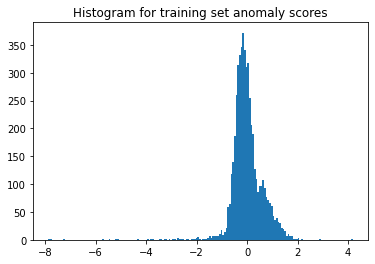

In [26]:
plt.hist(train_scores, bins='auto')
plt.title("Histogram for training set anomaly scores")
plt.show()

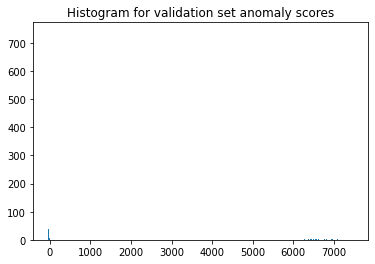

In [27]:
plt.hist(val_scores, bins='auto')
plt.title("Histogram for validation set anomaly scores")
plt.show()

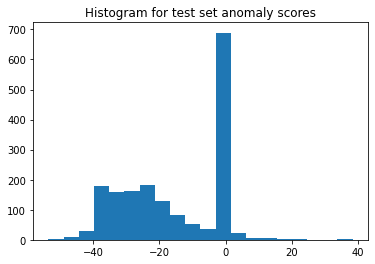

In [28]:
plt.hist(test_scores, bins='auto')
plt.title("Histogram for test set anomaly scores")
plt.show()

Let data points with scores above 2.5 be considered as outliers. 

In [29]:
outlier_threshold = 2.5

Training set

In [30]:
train_outlier_index = []
for order in range(0, len(train_scores)):
    if (train_scores[order] > outlier_threshold) or (train_scores[order] < -outlier_threshold):
        train_outlier_index.append(order)

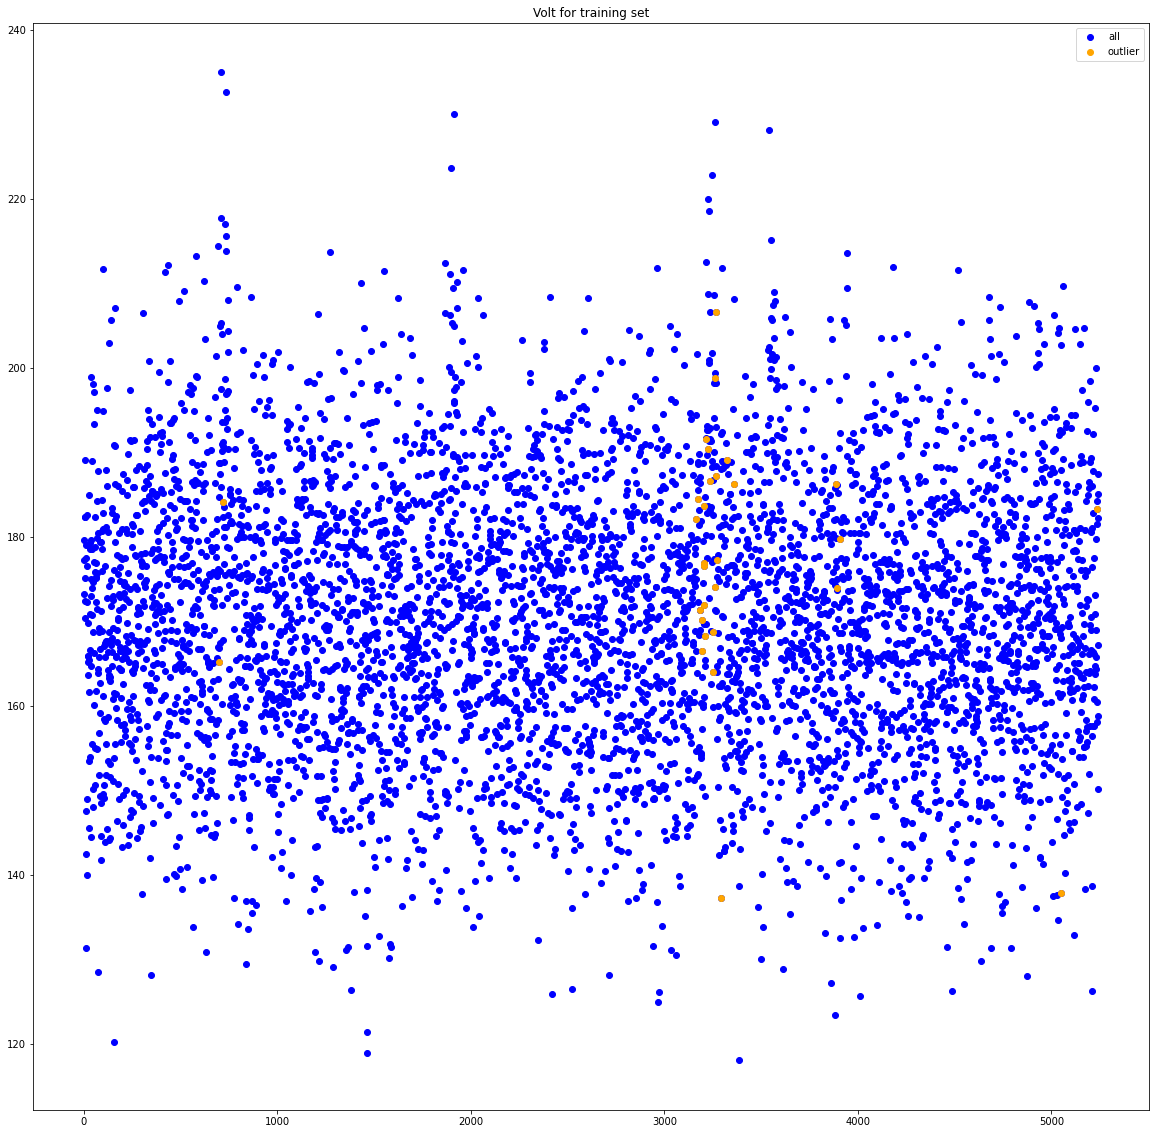

In [31]:
#volt
volt_train = volt[0:num_train]
volt_train_indexes = [i for i in range(0, len(volt_train))]
volt_train_outlier = []
for i in train_outlier_index:
    volt_train_outlier.append(volt_train[i])

plt.figure(figsize=(20,20))
plt.title('Volt for training set')
plt.scatter(volt_train_indexes, volt_train, color='blue', label='all')
plt.scatter(train_outlier_index, volt_train_outlier, color='orange', label='outlier')
plt.legend()
plt.show()

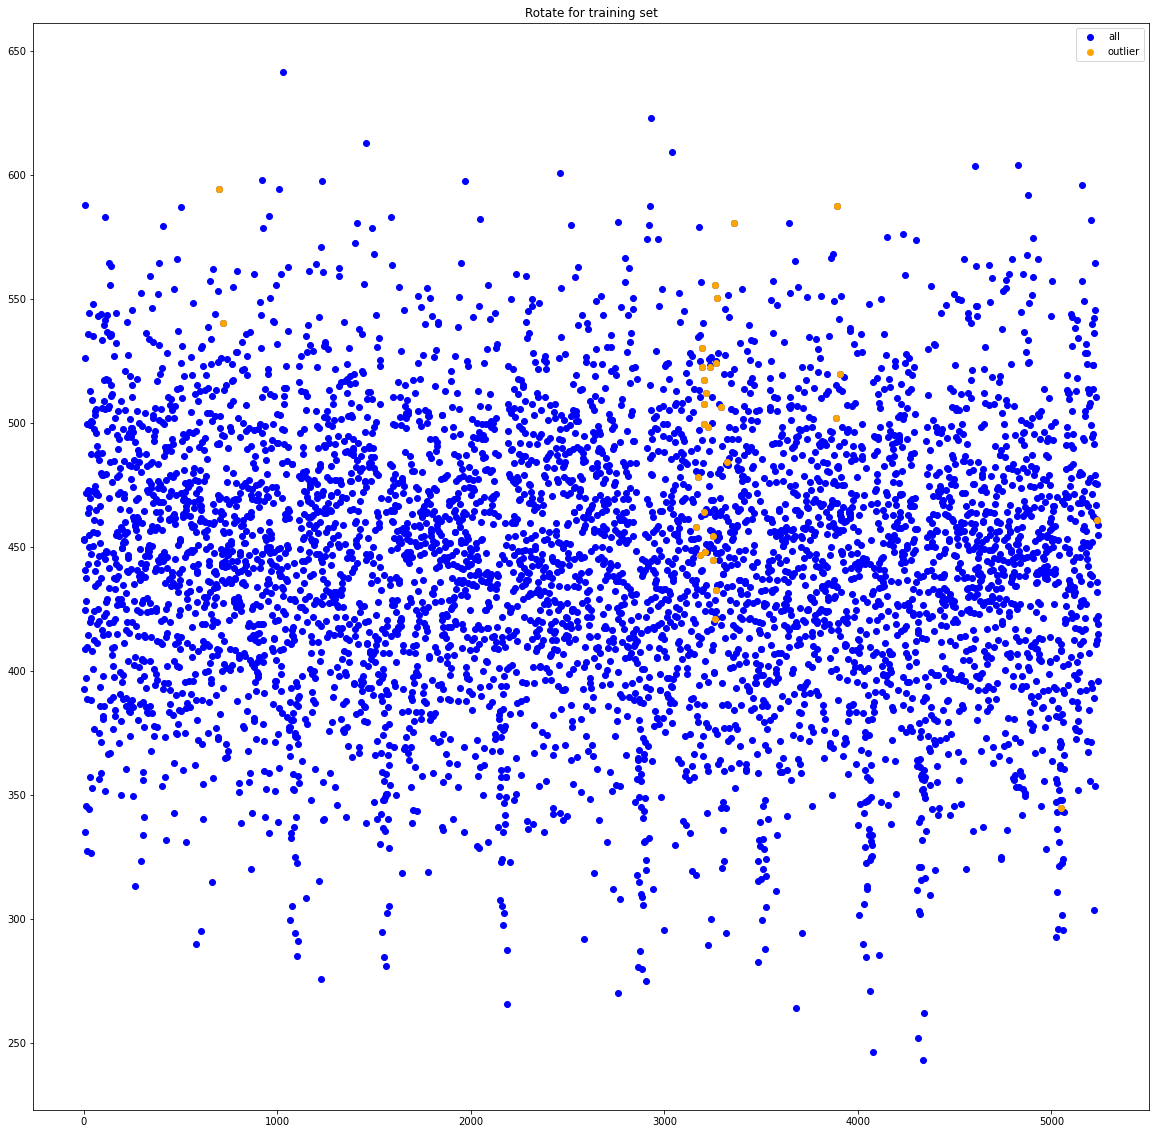

In [32]:
#rotate
rotate_train = rotate[0:num_train]
rotate_train_indexes = [i for i in range(0, len(rotate_train))]
rotate_train_outlier = []
for i in train_outlier_index:
    rotate_train_outlier.append(rotate_train[i])

plt.figure(figsize=(20,20))
plt.title('Rotate for training set')
plt.scatter(rotate_train_indexes, rotate_train, color='blue', label='all')
plt.scatter(train_outlier_index, rotate_train_outlier, color='orange', label='outlier')
plt.legend()
plt.show()

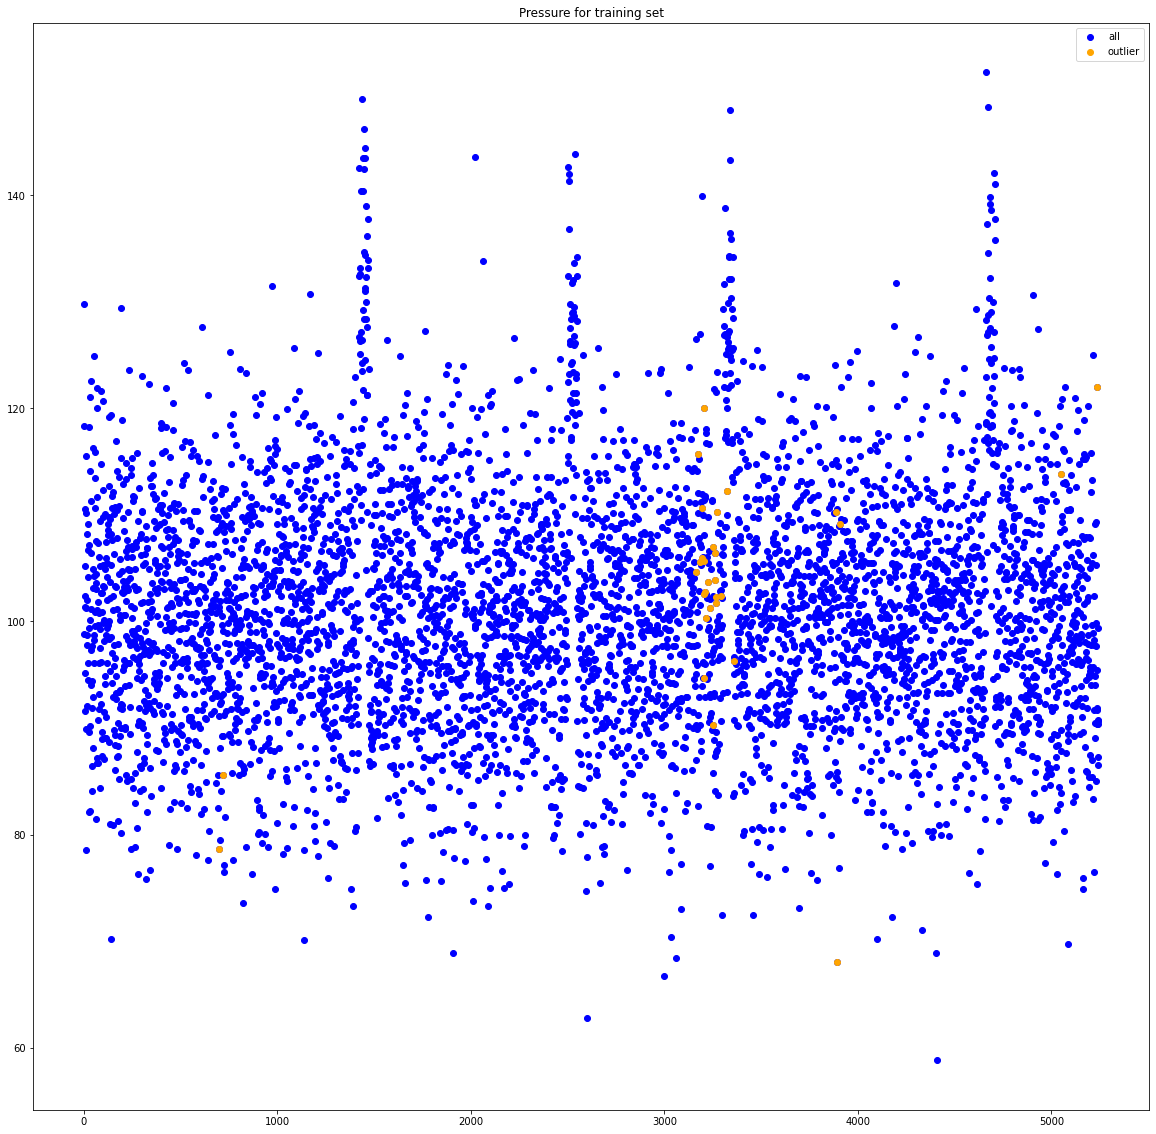

In [33]:
#pressure
pressure_train = pressure[0:num_train]
pressure_train_indexes = [i for i in range(0, len(pressure_train))]
pressure_train_outlier = []
for i in train_outlier_index:
    pressure_train_outlier.append(pressure_train[i])

plt.figure(figsize=(20,20))
plt.title('Pressure for training set')
plt.scatter(pressure_train_indexes, pressure_train, color='blue', label='all')
plt.scatter(train_outlier_index, pressure_train_outlier, color='orange', label='outlier')
plt.legend()
plt.show()

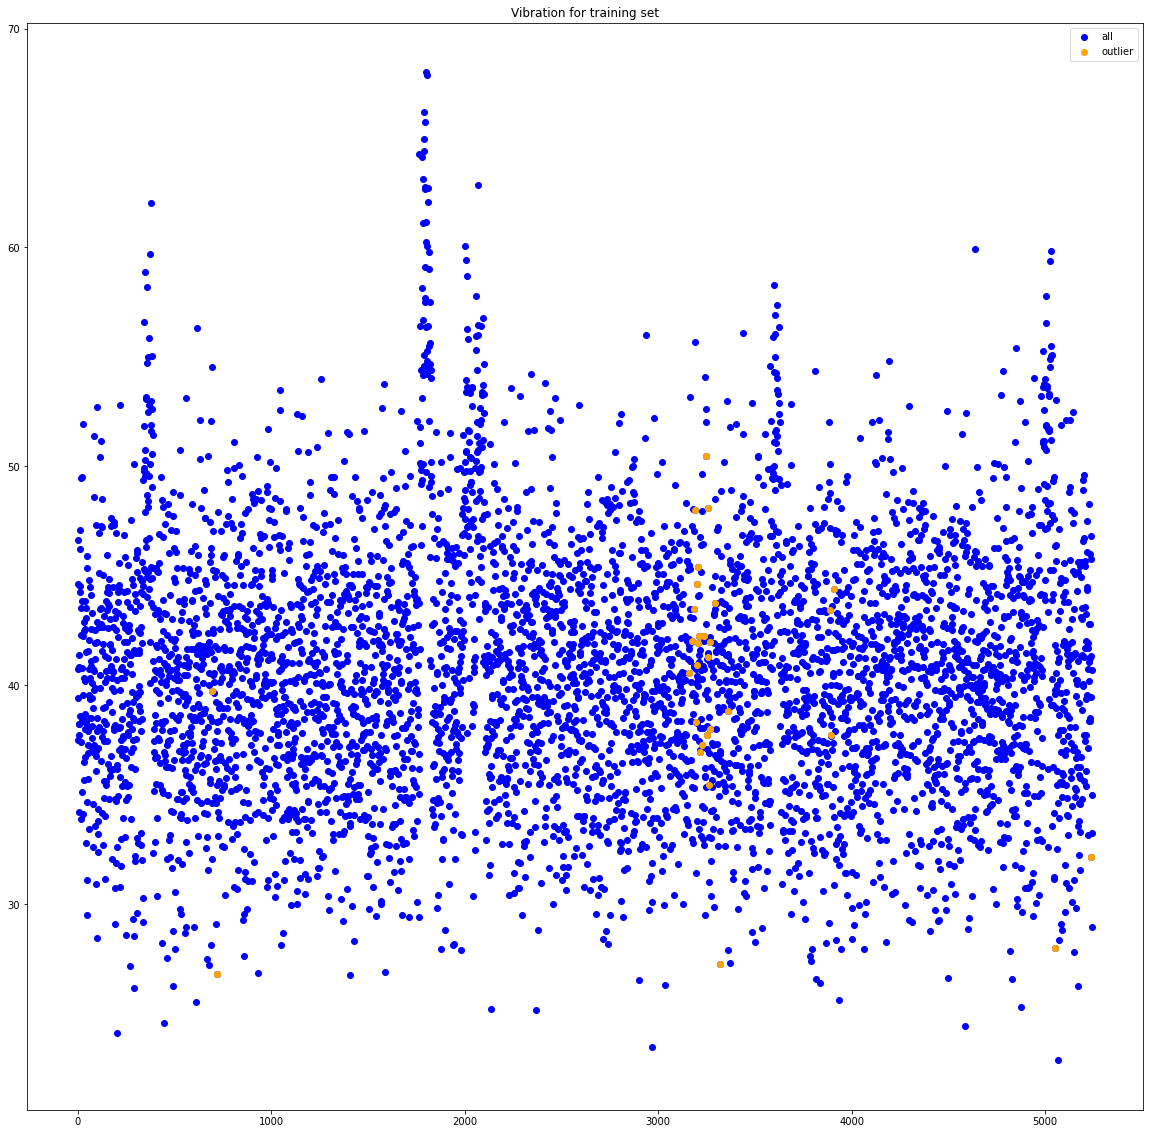

In [34]:
#vibration
vibration_train = vibration[0:num_train]
vibration_train_indexes = [i for i in range(0, len(vibration_train))]
vibration_train_outlier = []
for i in train_outlier_index:
    vibration_train_outlier.append(vibration_train[i])

plt.figure(figsize=(20,20))
plt.title('Vibration for training set')
plt.scatter(vibration_train_indexes, vibration_train, color='blue', label='all')
plt.scatter(train_outlier_index, vibration_train_outlier, color='orange', label='outlier')
plt.legend()
plt.show()

Validation set

In [35]:
val_outlier_index = []
for order in range(0, len(val_scores)):
    if (val_scores[order] > outlier_threshold) or (val_scores[order] < -outlier_threshold):
        val_outlier_index.append(order)

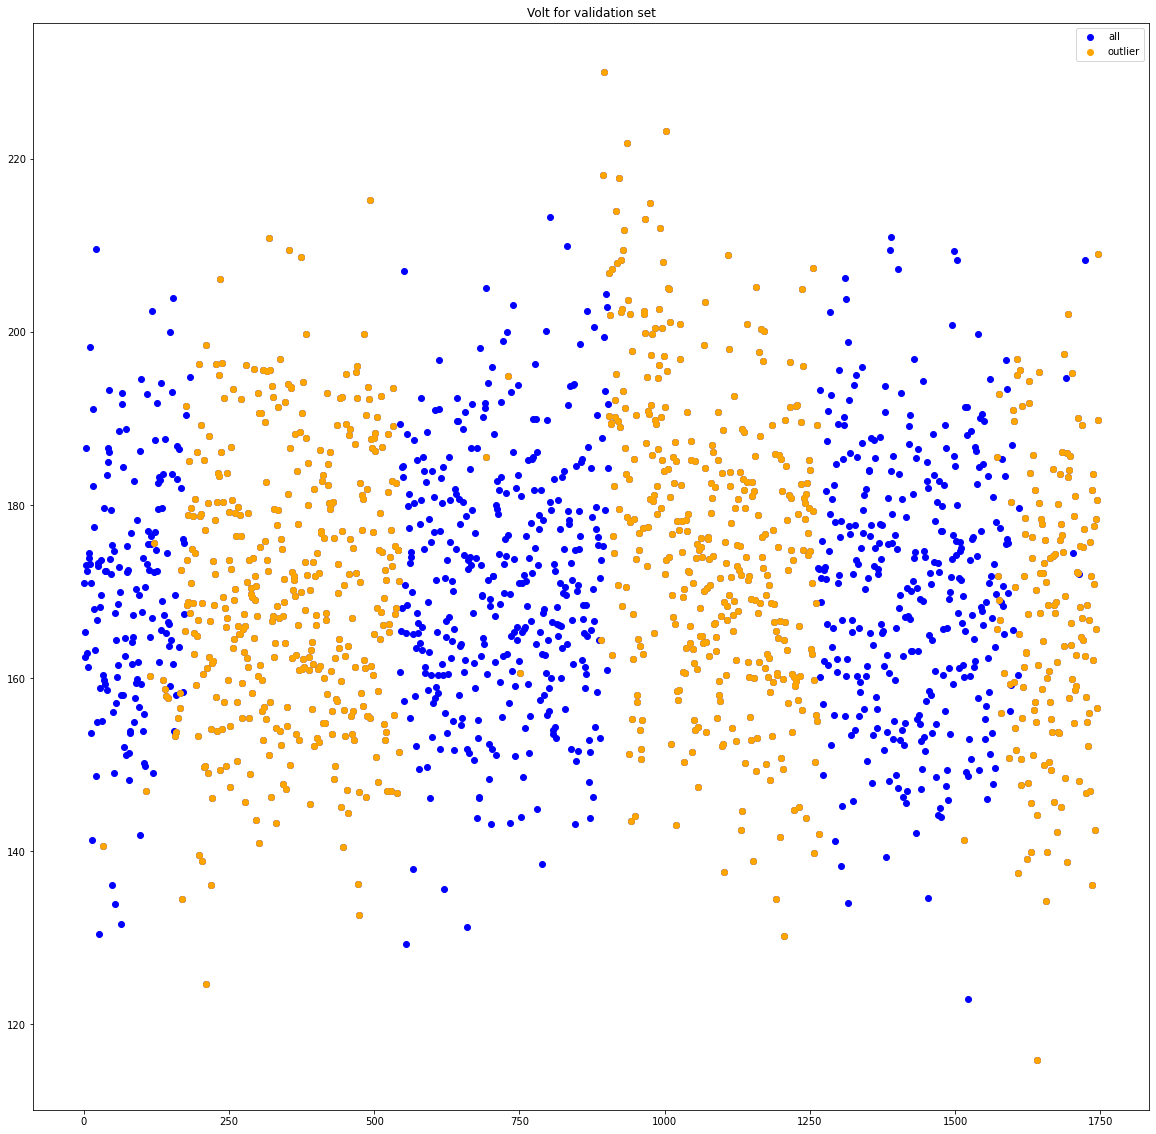

In [36]:
#volt
volt_val = volt[num_train: num_train+num_val]
volt_val_indexes = [i for i in range(0, len(volt_val))]
volt_val_outlier = []
for i in val_outlier_index:
    volt_val_outlier.append(volt_val[i])

plt.figure(figsize=(20,20))
plt.title('Volt for validation set')
plt.scatter(volt_val_indexes, volt_val, color='blue', label='all')
plt.scatter(val_outlier_index, volt_val_outlier, color='orange', label='outlier')
plt.legend()
plt.show()

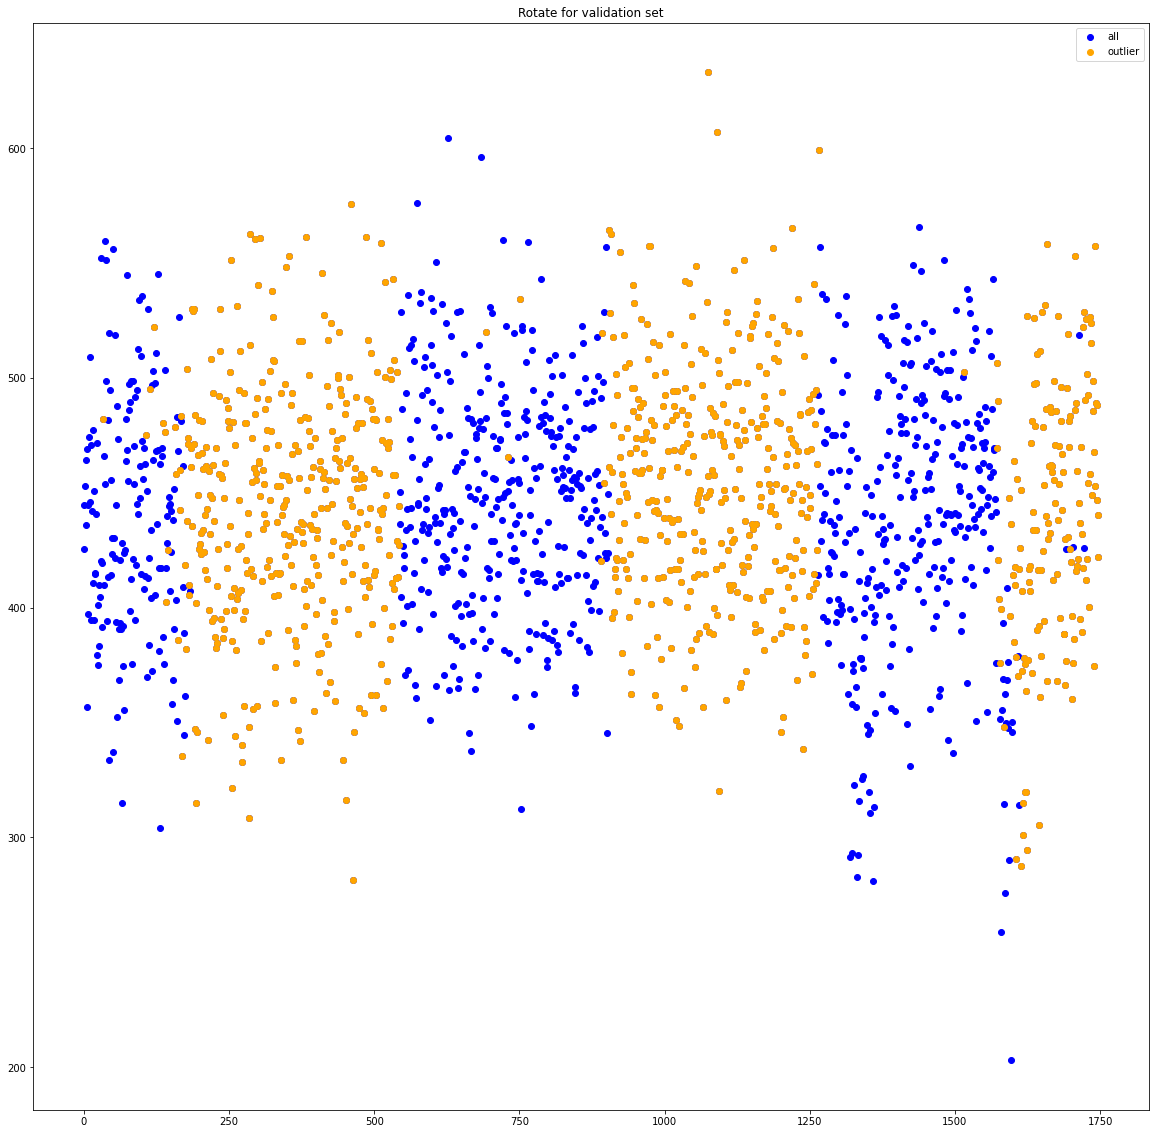

In [37]:
#rotate
rotate_val = rotate[num_train: num_train+num_val]
rotate_val_indexes = [i for i in range(0, len(rotate_val))]
rotate_val_outlier = []
for i in val_outlier_index:
    rotate_val_outlier.append(rotate_val[i])

plt.figure(figsize=(20,20))
plt.title('Rotate for validation set')
plt.scatter(rotate_val_indexes, rotate_val, color='blue', label='all')
plt.scatter(val_outlier_index, rotate_val_outlier, color='orange', label='outlier')
plt.legend()
plt.show()

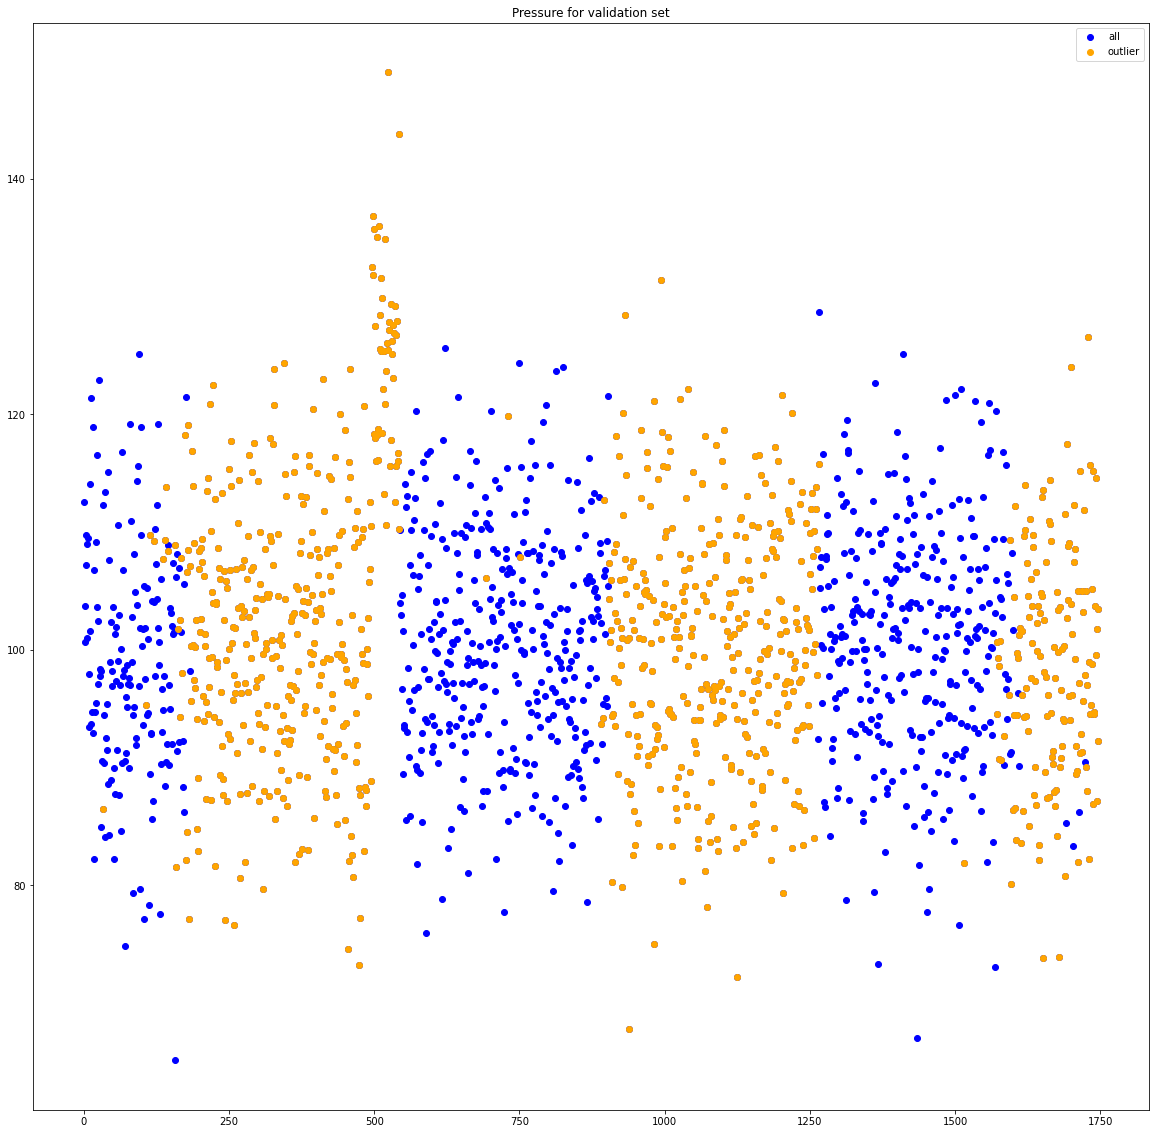

In [38]:
#pressure
pressure_val = pressure[num_train: num_train+num_val]
pressure_val_indexes = [i for i in range(0, len(pressure_val))]
pressure_val_outlier = []
for i in val_outlier_index:
    pressure_val_outlier.append(pressure_val[i])

plt.figure(figsize=(20,20))
plt.title('Pressure for validation set')
plt.scatter(pressure_val_indexes, pressure_val, color='blue', label='all')
plt.scatter(val_outlier_index, pressure_val_outlier, color='orange', label='outlier')
plt.legend()
plt.show()

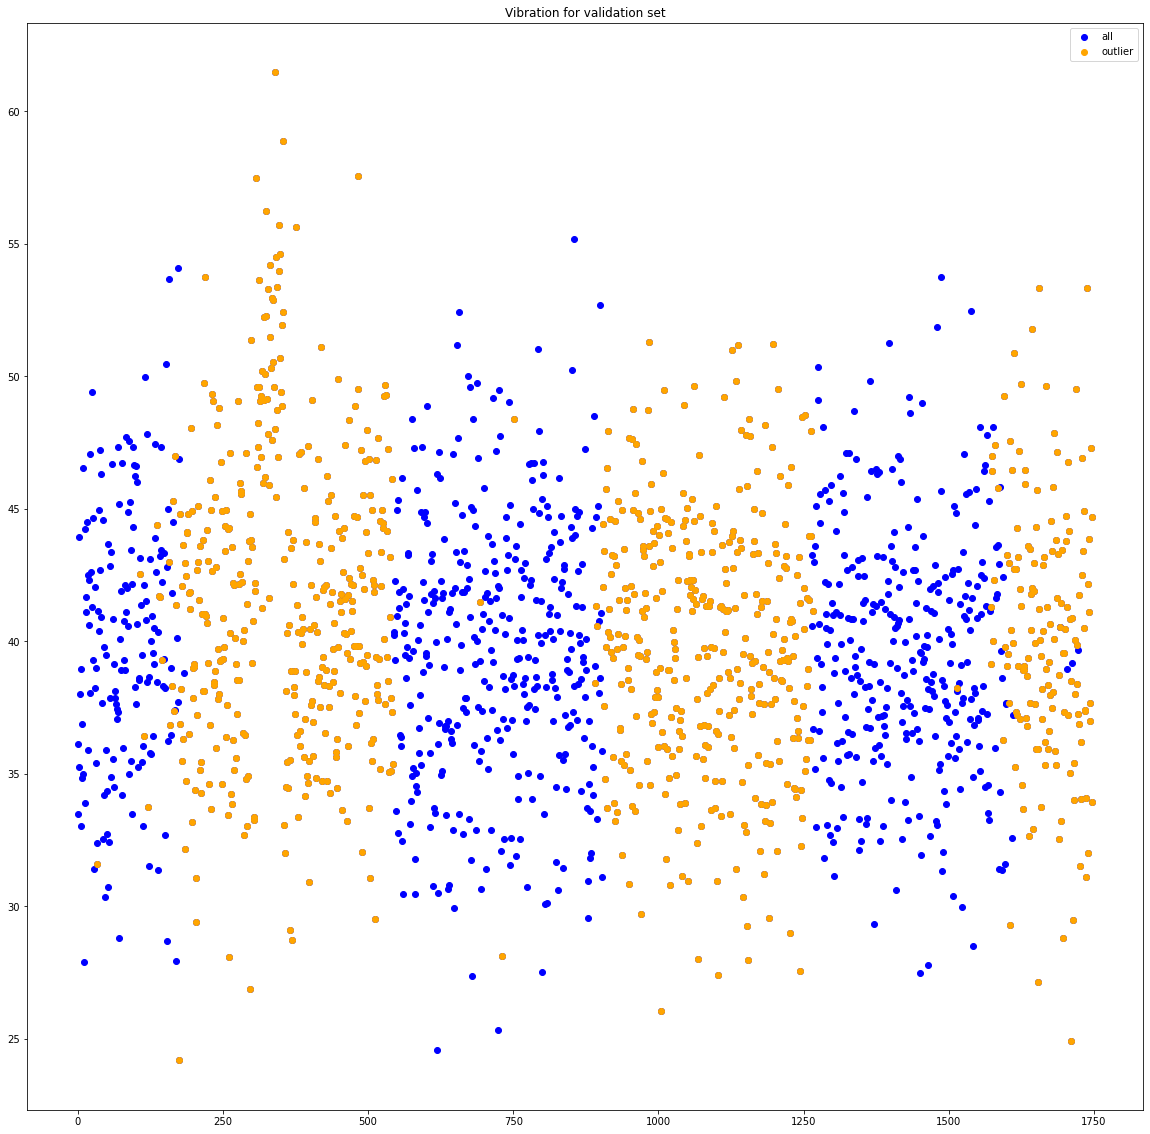

In [39]:
#vibration
vibration_val = vibration[num_train: num_train+num_val]
vibration_val_indexes = [i for i in range(0, len(vibration_val))]
vibration_val_outlier = []
for i in val_outlier_index:
    vibration_val_outlier.append(vibration_val[i])

plt.figure(figsize=(20,20))
plt.title('Vibration for validation set')
plt.scatter(vibration_val_indexes, vibration_val, color='blue', label='all')
plt.scatter(val_outlier_index, vibration_val_outlier, color='orange', label='outlier')
plt.legend()
plt.show()

Test set

In [40]:
test_outlier_index = []
for order in range(0, len(test_scores)):
    if (test_scores[order] > outlier_threshold) or (test_scores[order] < -outlier_threshold):
        test_outlier_index.append(order)

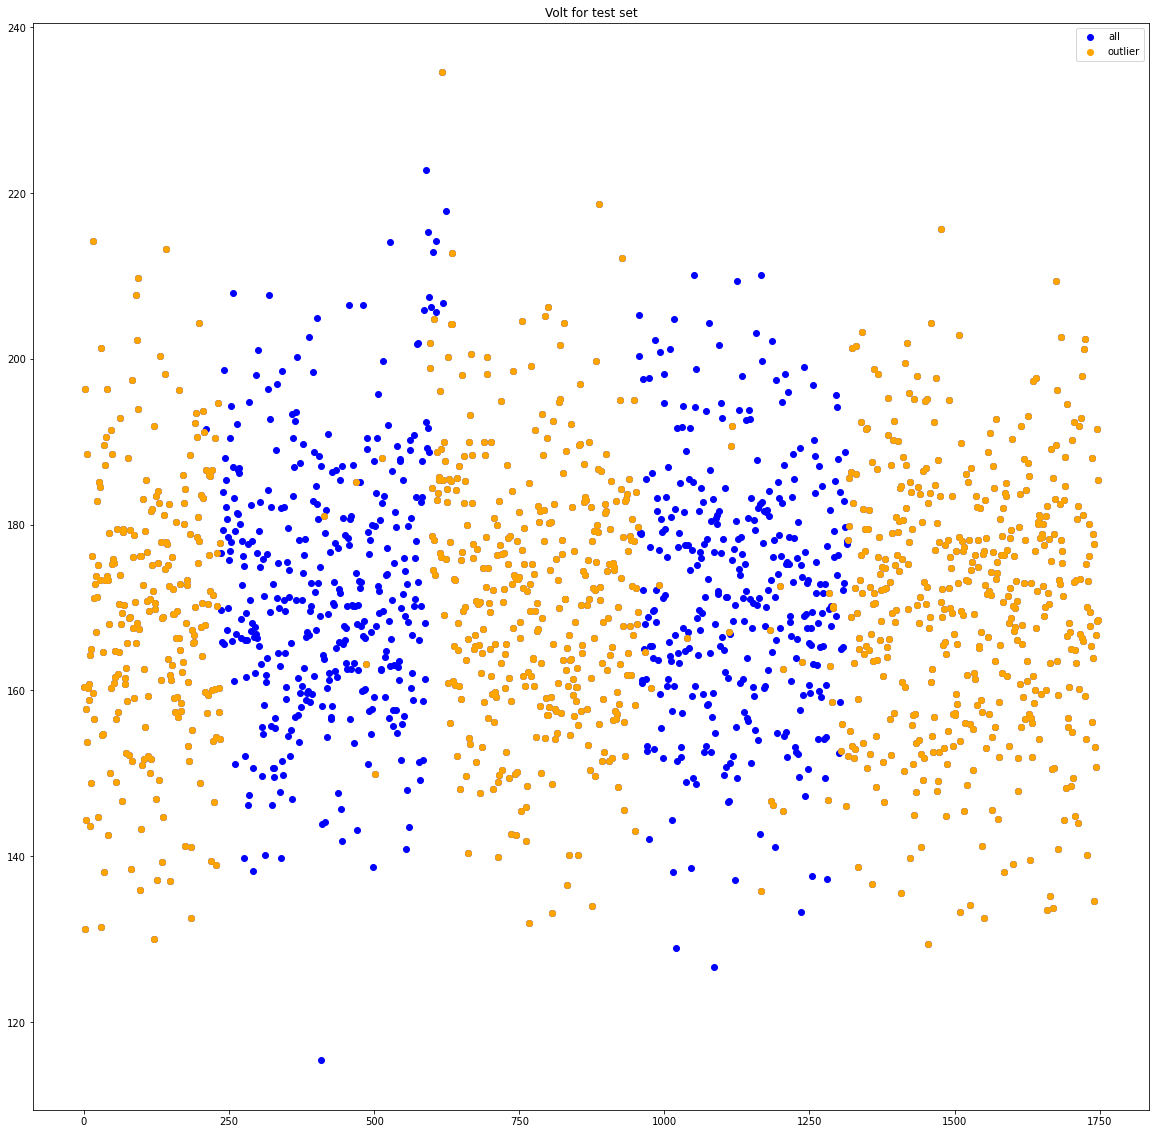

In [41]:
#volt
volt_test = volt[num_train+num_val:]
volt_test_indexes = [i for i in range(0, len(volt_test))]
volt_test_outlier = []
for i in test_outlier_index:
    volt_test_outlier.append(volt_test[i])

plt.figure(figsize=(20,20))
plt.title('Volt for test set')
plt.scatter(volt_test_indexes, volt_test, color='blue', label='all')
plt.scatter(test_outlier_index, volt_test_outlier, color='orange', label='outlier')
plt.legend()
plt.show()

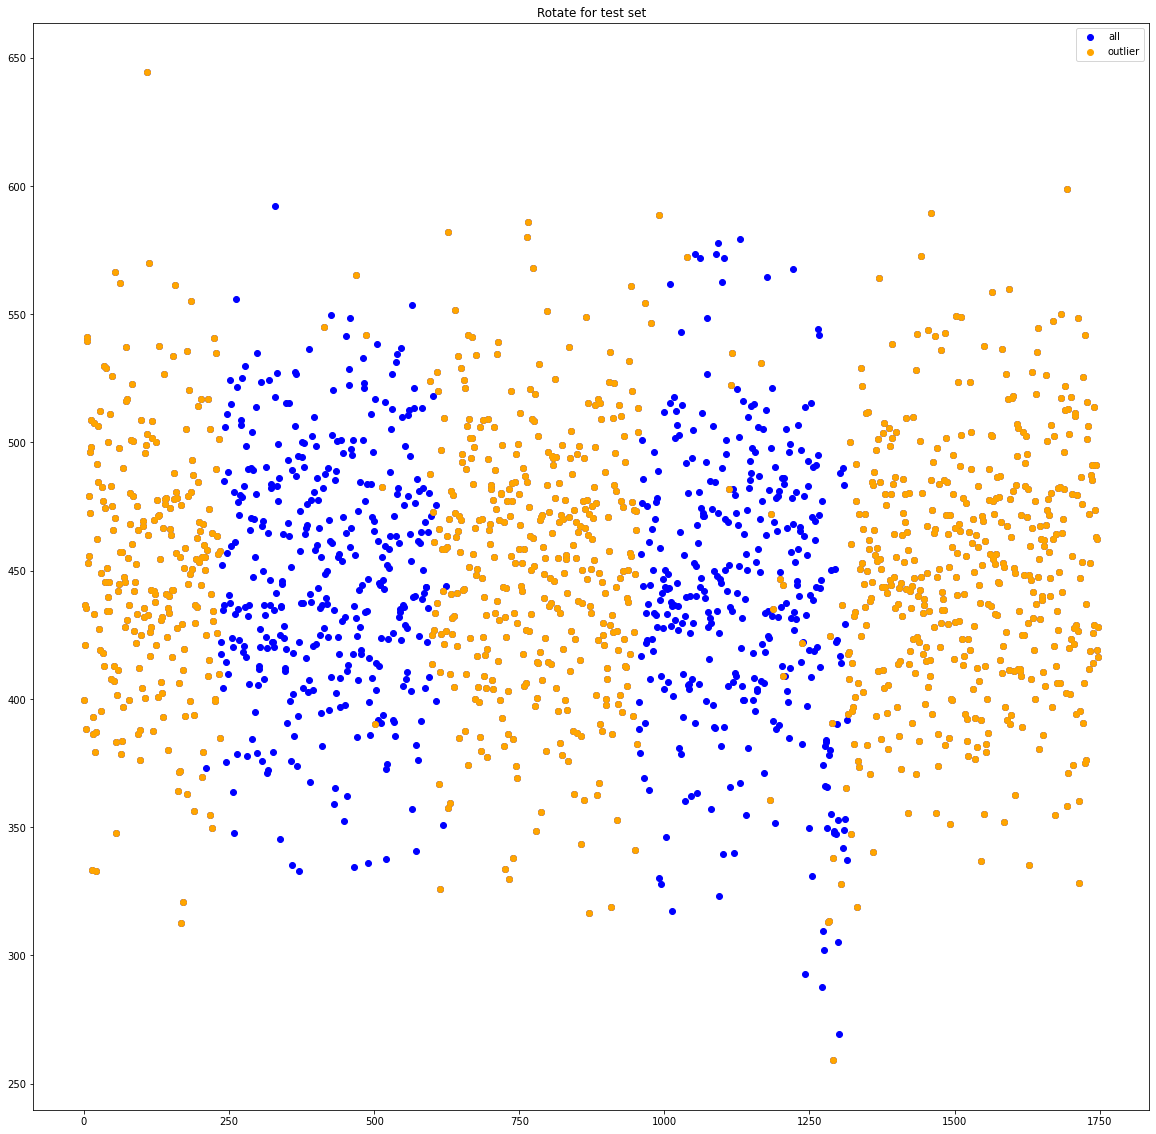

In [42]:
#rotate
rotate_test = rotate[num_train+num_val:]
rotate_test_indexes = [i for i in range(0, len(rotate_test))]
rotate_test_outlier = []
for i in test_outlier_index:
    rotate_test_outlier.append(rotate_test[i])

plt.figure(figsize=(20,20))
plt.title('Rotate for test set')
plt.scatter(rotate_test_indexes, rotate_test, color='blue', label='all')
plt.scatter(test_outlier_index, rotate_test_outlier, color='orange', label='outlier')
plt.legend()
plt.show()

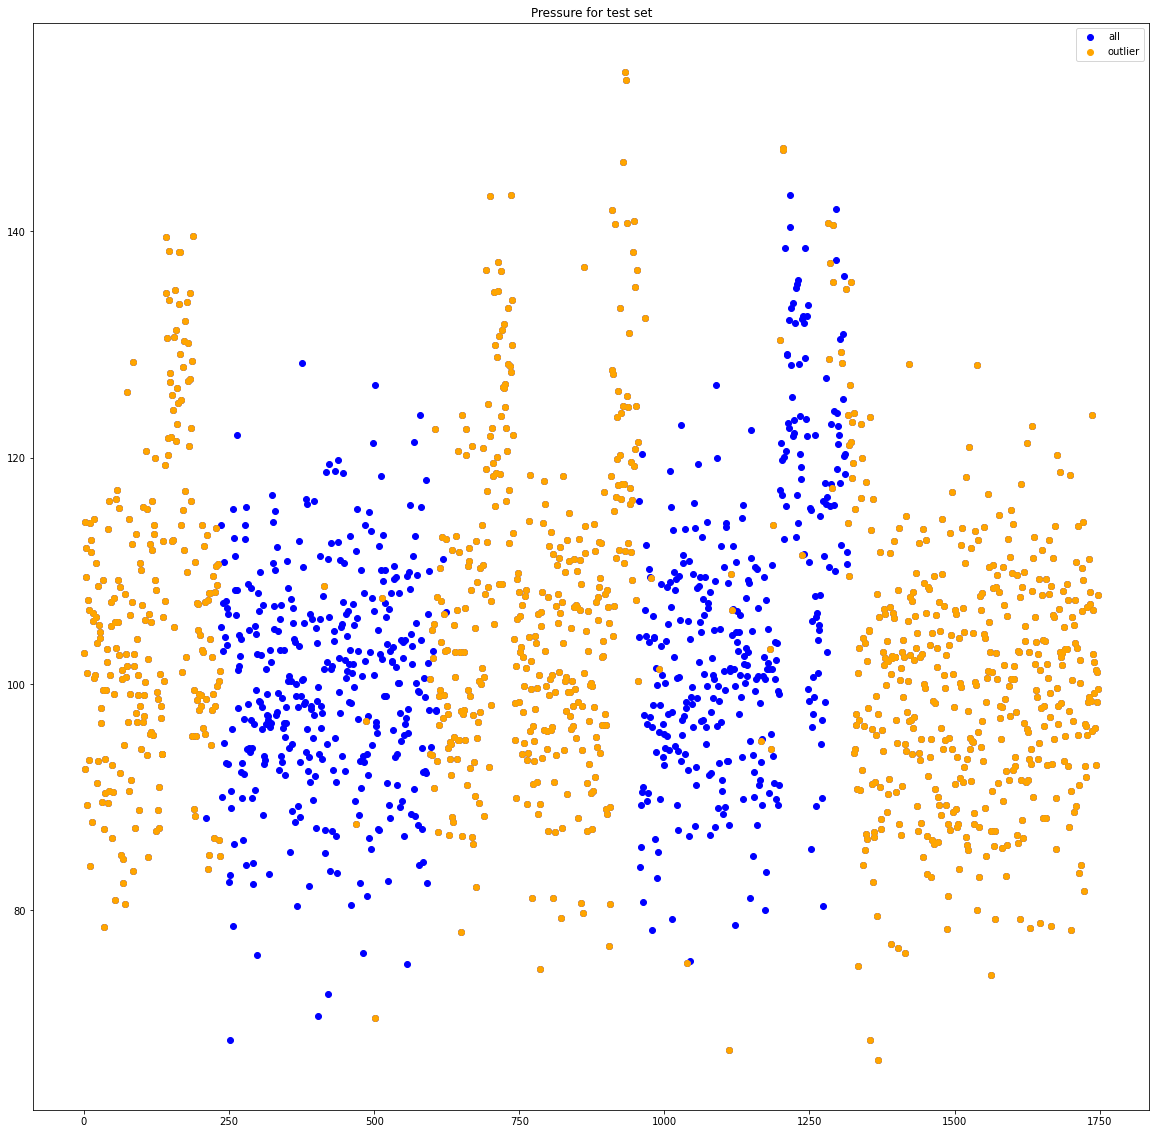

In [43]:
#pressure
pressure_test = pressure[num_train+num_val:]
pressure_test_indexes = [i for i in range(0, len(pressure_test))]
pressure_test_outlier = []
for i in test_outlier_index:
    pressure_test_outlier.append(pressure_test[i])

plt.figure(figsize=(20,20))
plt.title('Pressure for test set')
plt.scatter(pressure_test_indexes, pressure_test, color='blue', label='all')
plt.scatter(test_outlier_index, pressure_test_outlier, color='orange', label='outlier')
plt.legend()
plt.show()

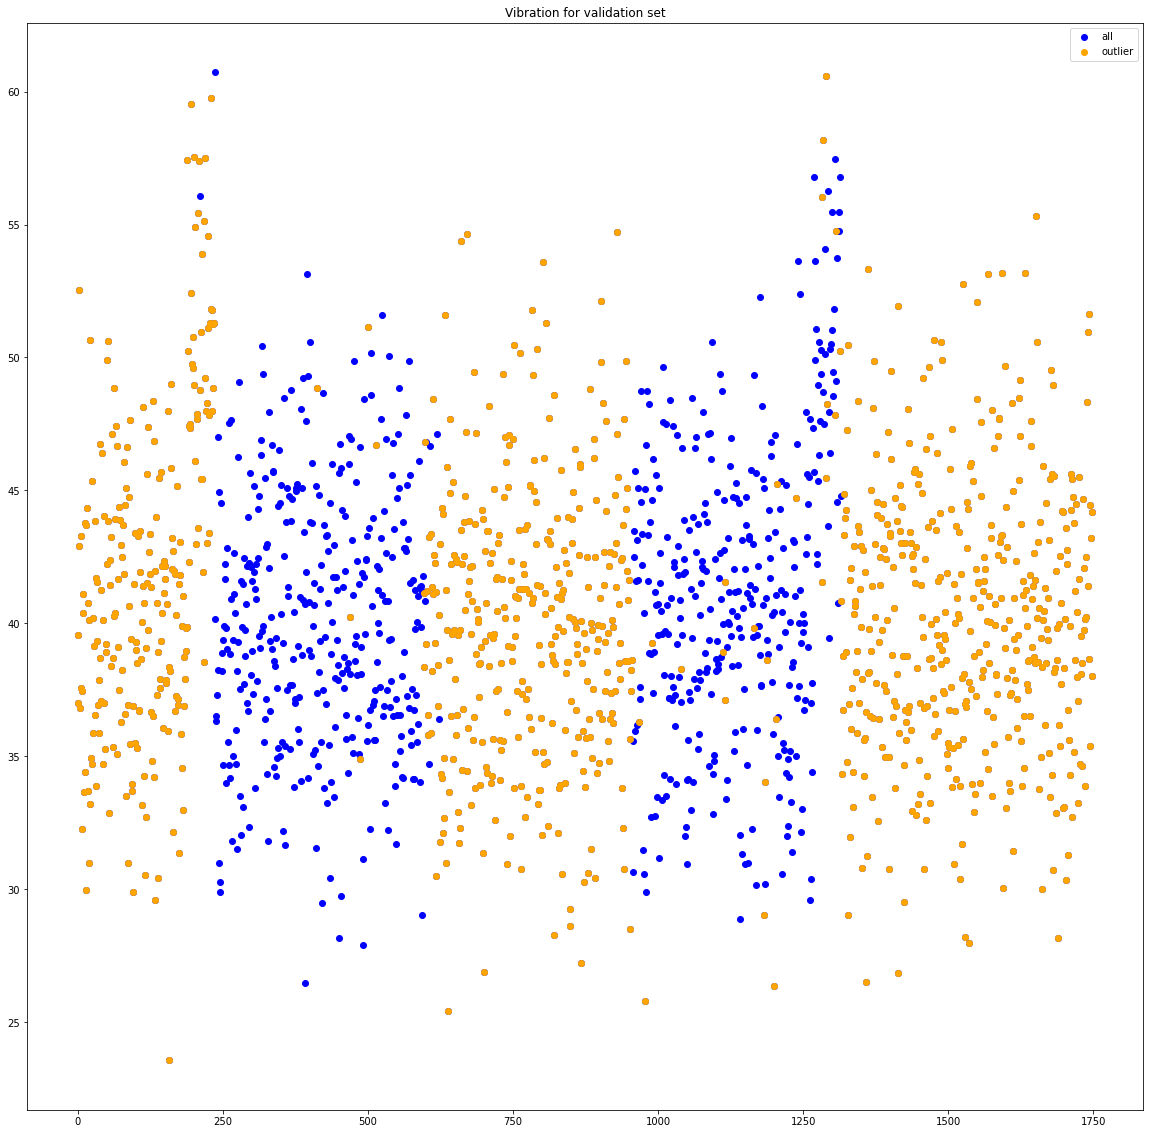

In [44]:
#vibration
vibration_test = vibration[num_train+num_val:]
vibration_test_indexes = [i for i in range(0, len(vibration_test))]
vibration_test_outlier = []
for i in test_outlier_index:
    vibration_test_outlier.append(vibration_test[i])

plt.figure(figsize=(20,20))
plt.title('Vibration for validation set')
plt.scatter(vibration_test_indexes, vibration_test, color='blue', label='all')
plt.scatter(test_outlier_index, vibration_test_outlier, color='orange', label='outlier')
plt.legend()
plt.show()

Increase outlier threshold for test set only to 30

In [45]:
outlier_threshold = 30

In [46]:
test_outlier_index = []
for order in range(0, len(test_scores)):
    if (test_scores[order] > outlier_threshold) or (test_scores[order] < -outlier_threshold):
        test_outlier_index.append(order)

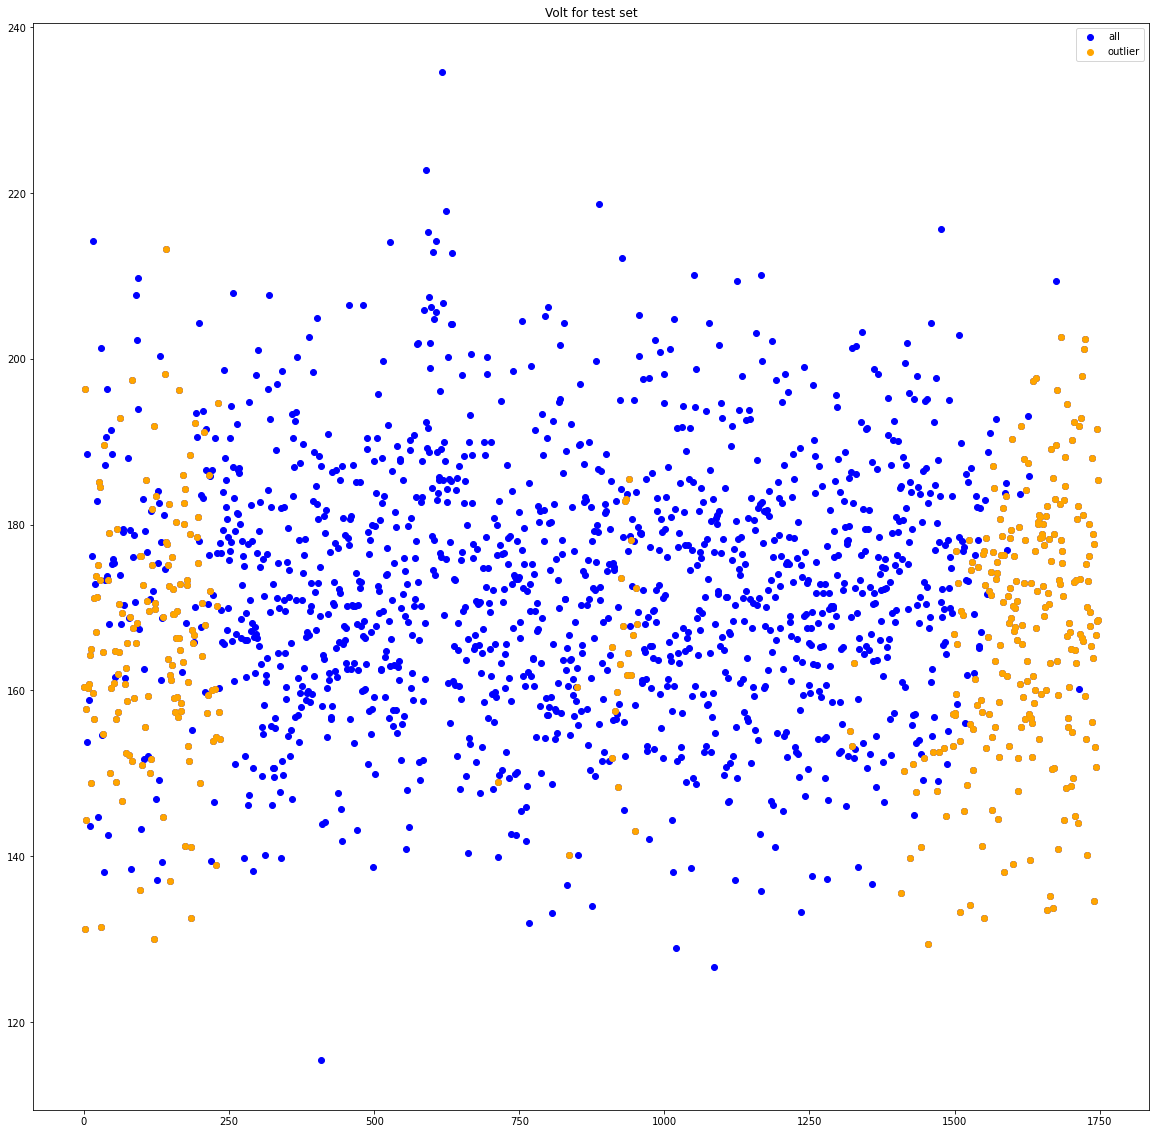

In [47]:
#volt
volt_test = volt[num_train+num_val:]
volt_test_indexes = [i for i in range(0, len(volt_test))]
volt_test_outlier = []
for i in test_outlier_index:
    volt_test_outlier.append(volt_test[i])

plt.figure(figsize=(20,20))
plt.title('Volt for test set')
plt.scatter(volt_test_indexes, volt_test, color='blue', label='all')
plt.scatter(test_outlier_index, volt_test_outlier, color='orange', label='outlier')
plt.legend()
plt.show()

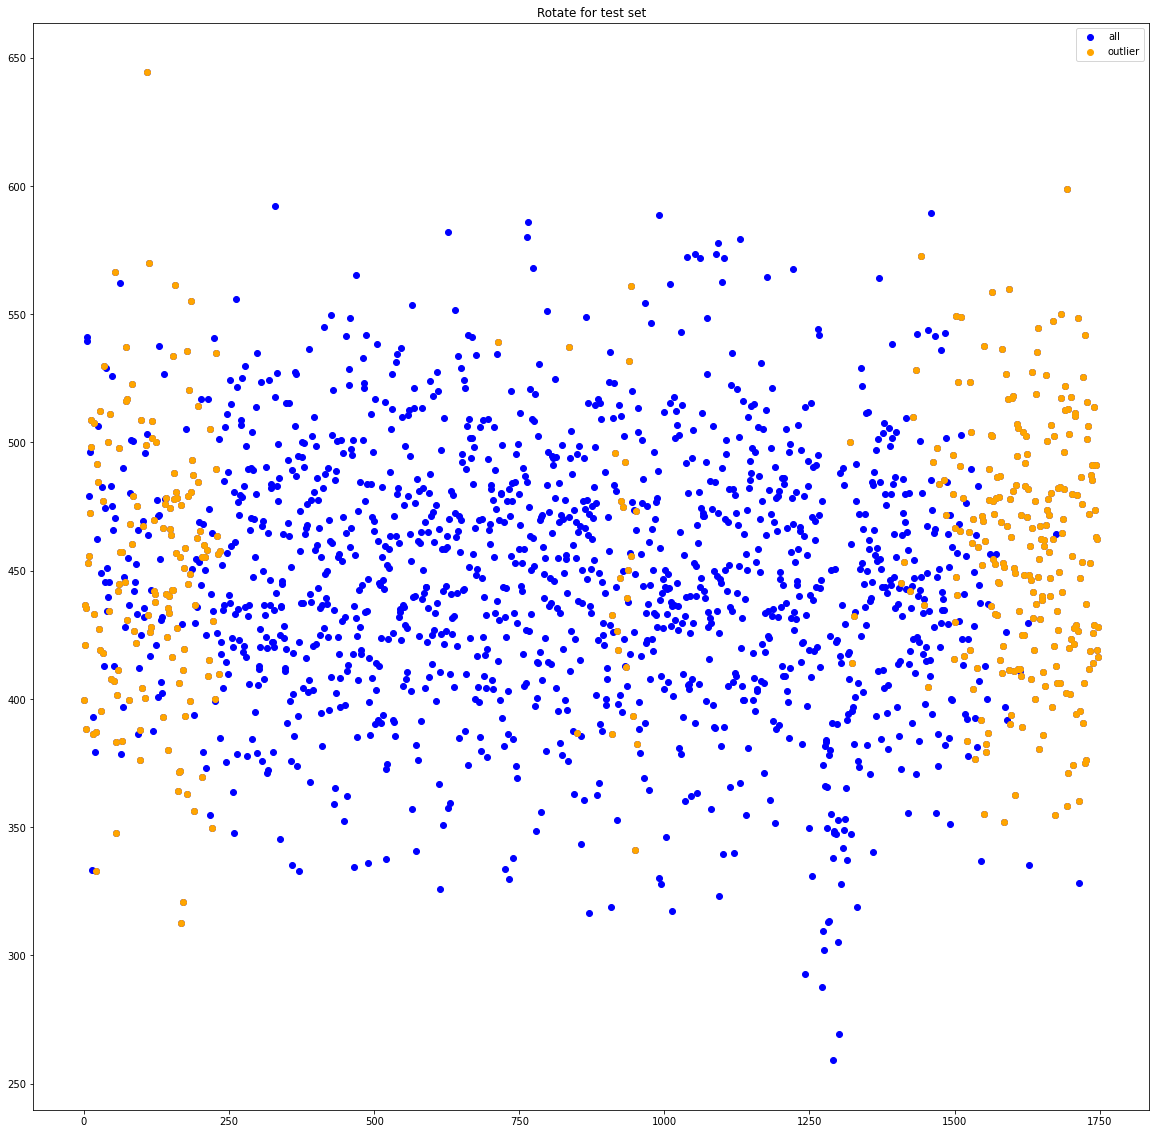

In [48]:
#rotate
rotate_test = rotate[num_train+num_val:]
rotate_test_indexes = [i for i in range(0, len(rotate_test))]
rotate_test_outlier = []
for i in test_outlier_index:
    rotate_test_outlier.append(rotate_test[i])

plt.figure(figsize=(20,20))
plt.title('Rotate for test set')
plt.scatter(rotate_test_indexes, rotate_test, color='blue', label='all')
plt.scatter(test_outlier_index, rotate_test_outlier, color='orange', label='outlier')
plt.legend()
plt.show()

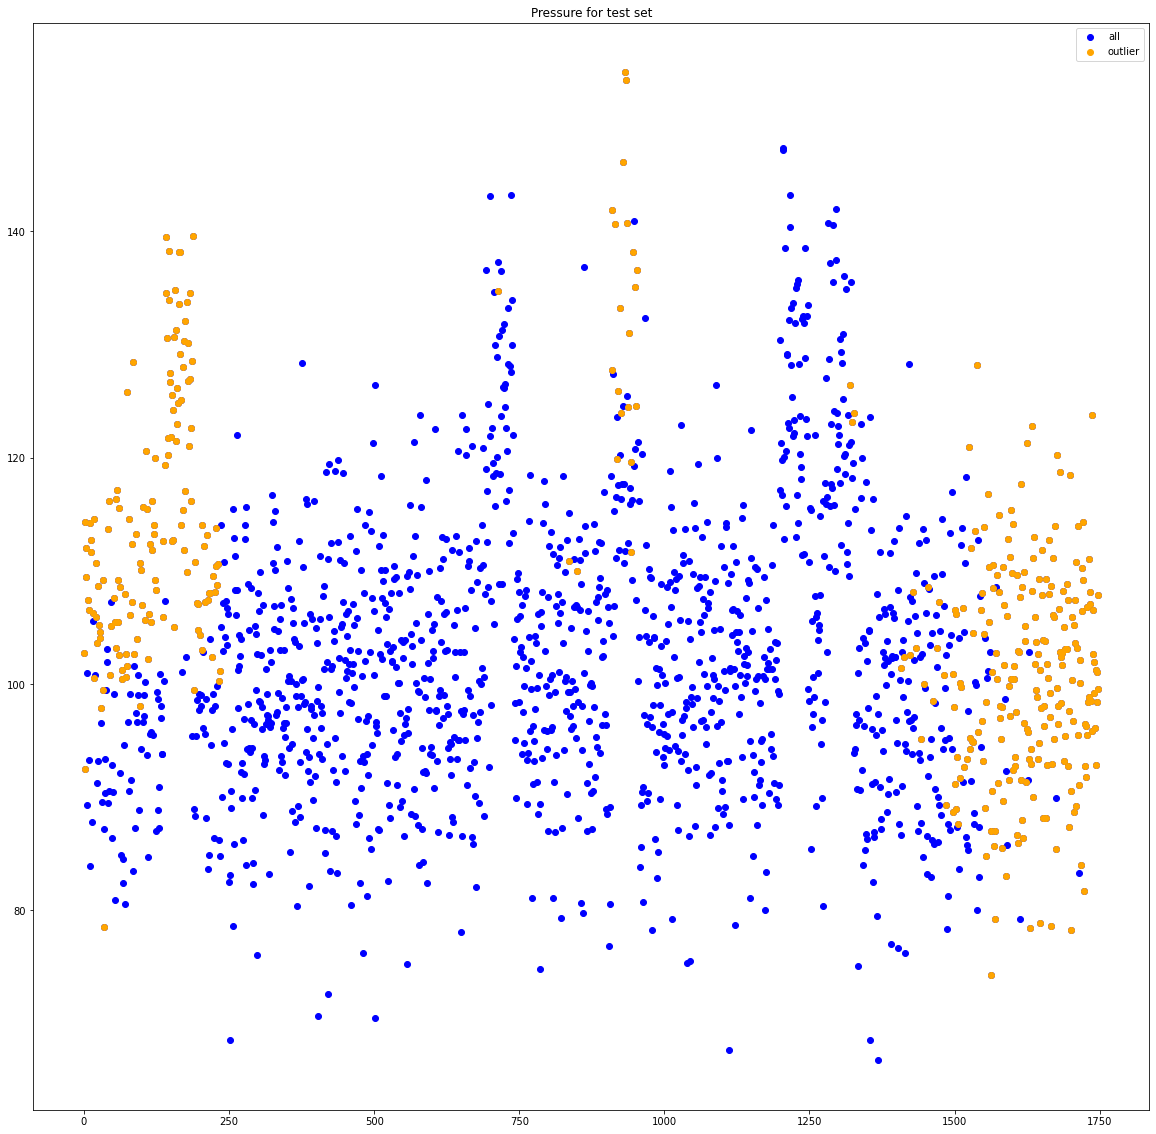

In [49]:
#pressure
pressure_test = pressure[num_train+num_val:]
pressure_test_indexes = [i for i in range(0, len(pressure_test))]
pressure_test_outlier = []
for i in test_outlier_index:
    pressure_test_outlier.append(pressure_test[i])

plt.figure(figsize=(20,20))
plt.title('Pressure for test set')
plt.scatter(pressure_test_indexes, pressure_test, color='blue', label='all')
plt.scatter(test_outlier_index, pressure_test_outlier, color='orange', label='outlier')
plt.legend()
plt.show()

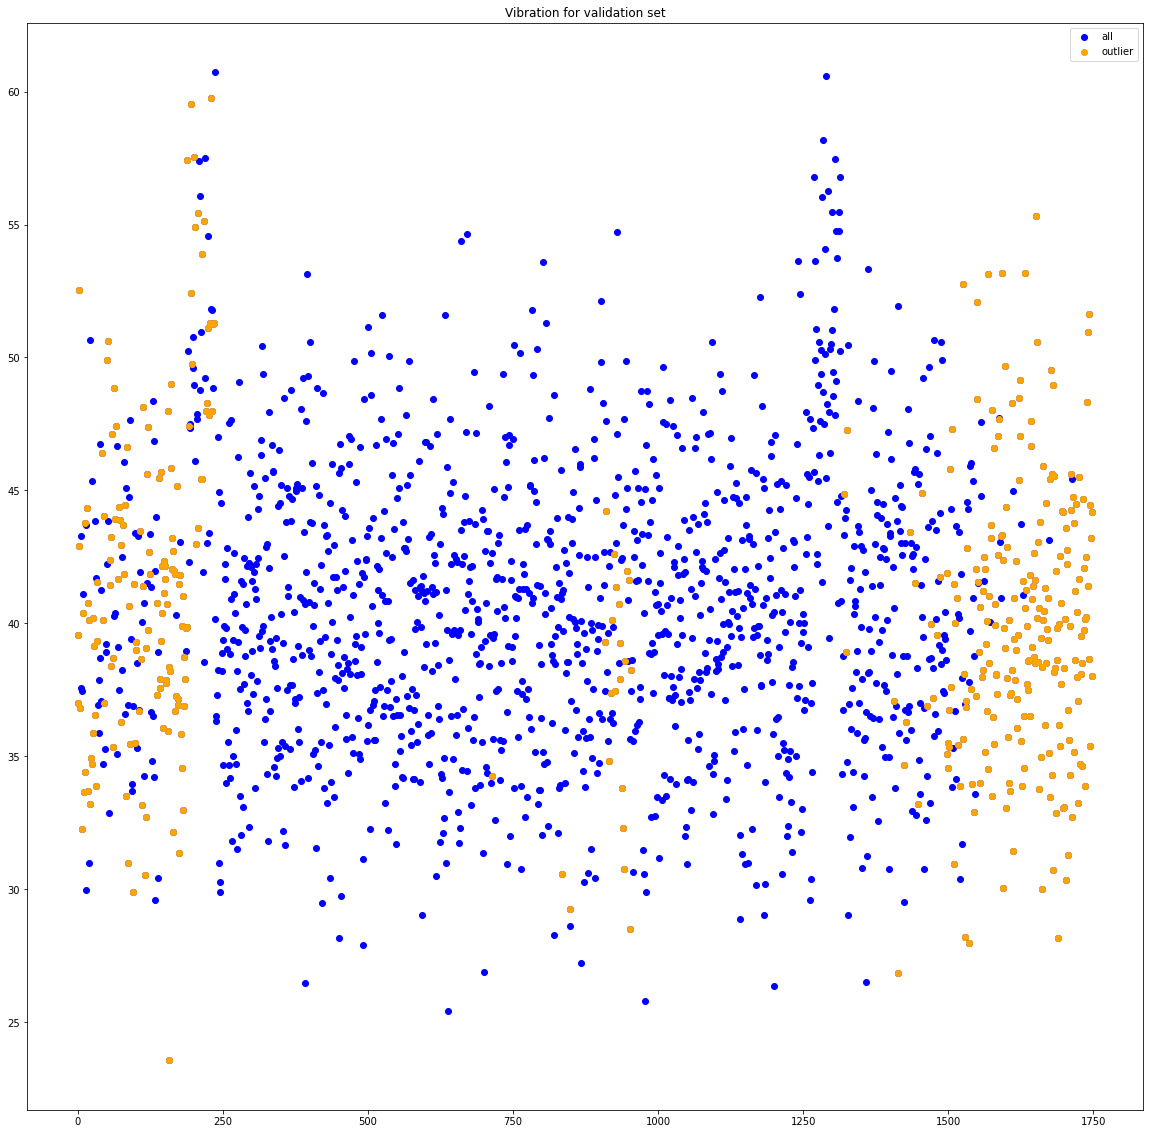

In [50]:
#vibration
vibration_test = vibration[num_train+num_val:]
vibration_test_indexes = [i for i in range(0, len(vibration_test))]
vibration_test_outlier = []
for i in test_outlier_index:
    vibration_test_outlier.append(vibration_test[i])

plt.figure(figsize=(20,20))
plt.title('Vibration for validation set')
plt.scatter(vibration_test_indexes, vibration_test, color='blue', label='all')
plt.scatter(test_outlier_index, vibration_test_outlier, color='orange', label='outlier')
plt.legend()
plt.show()